# Medical Diagnosis Classification using SVM and Decision Trees

## Scenario and Questions

You are working as a data scientist intern at a diabetes research center. The center has collected health data from 200 patients including their age, BMI, glucose levels, blood pressure, insulin levels, physical activity, and family history of diabetes. Your task is to build predictive models that can help identify patients at risk of developing diabetes based on these health metrics.

### Questions to answer:
1. Which health metrics are most strongly associated with diabetes risk?
2. Can we build an accurate model to predict diabetes risk using patient health data?
3. Which algorithm performs better for this task: Support Vector Machines or Decision Trees?
4. How does changing algorithm parameters (like SVM kernel or tree depth) affect model performance?
5. How can we handle missing test results in the patient data?
6. Which model would you recommend for deployment in a clinical setting and why?

## Introduction

In this assignment, you will work with a simplified medical dataset to predict whether a patient has a particular condition based on various health metrics.

You will learn how to:
1. Explore and preprocess a dataset
2. Implement and understand Support Vector Machines (SVM)
3. Implement and understand Decision Trees (DT)
4. Compare the performance of these two algorithms

## Setup: Import necessary libraries

First, let's import all the libraries we'll need for this analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree

# Set plot style for better visualization in Colab
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")

# For reproducible results
np.random.seed(42)

In [2]:
#plt.style.available

## Creating a Synthetic Medical Dataset

Here we create a synthetic medical dataset that simulates patient information for diabetes risk assessment. This approach allows us to work with realistic data while understanding the underlying patterns.

In [3]:
# 200 patients with the following features:
# - Age: age of the patient (years)
# - BMI: Body Mass Index
# - Glucose: Fasting blood glucose level (mg/dL)
# - BloodPressure: Blood pressure measurement (mm Hg)
# - Insulin: Insulin level (μU/mL)
# - PhysicalActivity: Hours of physical activity per week
# - FamilyHistory: Binary (0 = No family history of diabetes, 1 = Has family history)
# - Diagnosis: Target variable (0 = Healthy, 1 = Diabetic)

n_samples = 200

# Generate feature data
age = np.random.normal(45, 15, n_samples).astype(int)
age = np.clip(age, 18, 85)  # Clip age between 18 and 85

bmi = np.random.normal(26, 5, n_samples)
bmi = np.clip(bmi, 16, 45)  # Clip BMI between 16 and 45

glucose = np.random.normal(100, 25, n_samples)
glucose = np.clip(glucose, 70, 200)  # Clip glucose between 70 and 200

blood_pressure = np.random.normal(120, 15, n_samples)
blood_pressure = np.clip(blood_pressure, 80, 180)  # Clip BP between 80 and 180

insulin = np.random.normal(15, 10, n_samples)
insulin = np.clip(insulin, 2, 50)  # Clip insulin between 2 and 50

physical_activity = np.random.normal(3, 2, n_samples)
physical_activity = np.clip(physical_activity, 0, 10)  # Clip activity between 0 and 10 hours

family_history = np.random.binomial(1, 0.3, n_samples)  # 30% probability of having family history

### Creating the Target Variable

Now we'll create the diagnosis (target variable) based on the feature values. We're using a simplified model where higher risk factors include high glucose, high BMI, family history, low physical activity, and higher age.

In [4]:
# Create diagnosis based on feature values (simplified model)
# Higher risk factors: high glucose, high BMI, family history, low physical activity, higher age
diagnosis_prob = (0.01 * (glucose - 70) +
                 0.05 * (bmi - 18) +
                 0.3 * family_history +
                 0.02 * (age - 18) -
                 0.1 * physical_activity) / 10

diagnosis_prob = 1 / (1 + np.exp(-diagnosis_prob))  # Apply sigmoid to get probability between 0 and 1
diagnosis = (diagnosis_prob > 0.5).astype(int)  # Convert to binary classification

# Create pandas DataFrame
data = pd.DataFrame({
    'Age': age,
    'BMI': bmi,
    'Glucose': glucose,
    'BloodPressure': blood_pressure,
    'Insulin': insulin,
    'PhysicalActivity': physical_activity,
    'FamilyHistory': family_history,
    'Diagnosis': diagnosis
})

In [5]:
diagnosis_prob>0.5 # severe class imablance from the sigmoid function???

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Adding Missing Values

Real-world medical data often contains missing values. Let's introduce some missing values to make our preprocessing more realistic.

In [6]:
# Introduce some missing values to make preprocessing more realistic
# This step is important because real-world data is often messy
rows_indices = np.random.choice(n_samples, size=15, replace=False)
cols_indices = np.random.choice(5, size=15, replace=True)  # Only add missing values to the first 5 columns
col_names = data.columns[:5]

for i, j in zip(rows_indices, cols_indices):
    data.loc[i, col_names[j]] = np.nan

# Save the dataset to a CSV file for future use
data.to_csv('diabetes_risk_data.csv', index=False)

# Now let's load the dataset as if we just got it (good practice for a workflow)
df = pd.read_csv('diabetes_risk_data.csv')

## Part 1: Data Exploration

Let's explore our dataset to understand its structure and characteristics.

In [7]:
print("Dataset Overview:")
print("-----------------")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Information:")
df.info()

Dataset Overview:
-----------------
Dataset shape: (200, 8)

First 5 rows:


,Age,BMI,Glucose,BloodPressure,Insulin,PhysicalActivity,FamilyHistory,Diagnosis
0,52.0,27.788937,70.000000,131.354829,24.382838,5.798711,0,1
1,42.0,28.803923,85.015624,106.167520,9.839553,4.849267,0,1
2,54.0,31.415256,100.131092,133.044089,15.961208,3.119261,1,1
3,67.0,31.269010,NaN,140.334568,10.377247,1.706126,0,1
4,41.0,19.111653,88.748363,126.201524,10.655038,4.396447,1,1



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               196 non-null    float64
 1   BMI               196 non-null    float64
 2   Glucose           199 non-null    float64
 3   BloodPressure     196 non-null    float64
 4   Insulin           198 non-null    float64
 5   PhysicalActivity  200 non-null    float64
 6   FamilyHistory     200 non-null    int64  
 7   Diagnosis         200 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 12.6 KB


In [8]:
print("Statistical Summary:")
display(df.describe())

print("\nTarget Variable Distribution:")
print(df['Diagnosis'].value_counts())
print(f"Percentage of diabetic patients: {df['Diagnosis'].mean() * 100:.2f}%")

Statistical Summary:


,Age,BMI,Glucose,BloodPressure,Insulin,PhysicalActivity,FamilyHistory,Diagnosis
count,196.000000,196.000000,199.000000,196.000000,198.000000,200.000000,200.000000,200.000000
mean,43.877551,26.546707,99.381376,120.180435,16.524000,3.326655,0.275000,0.980000
std,13.741769,4.834346,22.458192,15.368082,9.086700,1.933891,0.447635,0.140351
min,18.000000,16.000000,70.000000,80.000000,2.000000,0.000000,0.000000,0.000000
25%,34.000000,23.032366,80.127899,109.402962,9.711334,1.991748,0.000000,1.000000
50%,44.000000,26.447175,97.771999,120.408071,16.305370,3.395510,0.000000,1.000000
75%,52.000000,29.522157,114.339445,130.277657,22.088419,4.746932,1.000000,1.000000
max,85.000000,45.000000,176.972020,159.485731,40.269324,7.879505,1.000000,1.000000



Target Variable Distribution:
Diagnosis
1    196
0      4
Name: count, dtype: int64
Percentage of diabetic patients: 98.00%


Some missing values in: Age, BMI, Glucose, BP, and Insulin

Percentage of diabetic patients: 98.00%???

In [9]:
df[df['Diagnosis']==0]
# why are only 4/200 people not true for diabetes?

,Age,BMI,Glucose,BloodPressure,Insulin,PhysicalActivity,FamilyHistory,Diagnosis
23,23.0,17.936421,124.289274,140.181301,11.371614,7.284541,0,0
44,22.0,19.998518,70.000000,NaN,16.664522,2.654745,0,0
49,18.0,28.024909,73.519662,130.443095,9.690030,5.760183,0,0
62,28.0,16.000000,82.506862,119.508701,30.475052,5.297531,1,0


### Data Visualization

Let's visualize our data to better understand the distributions and relationships.

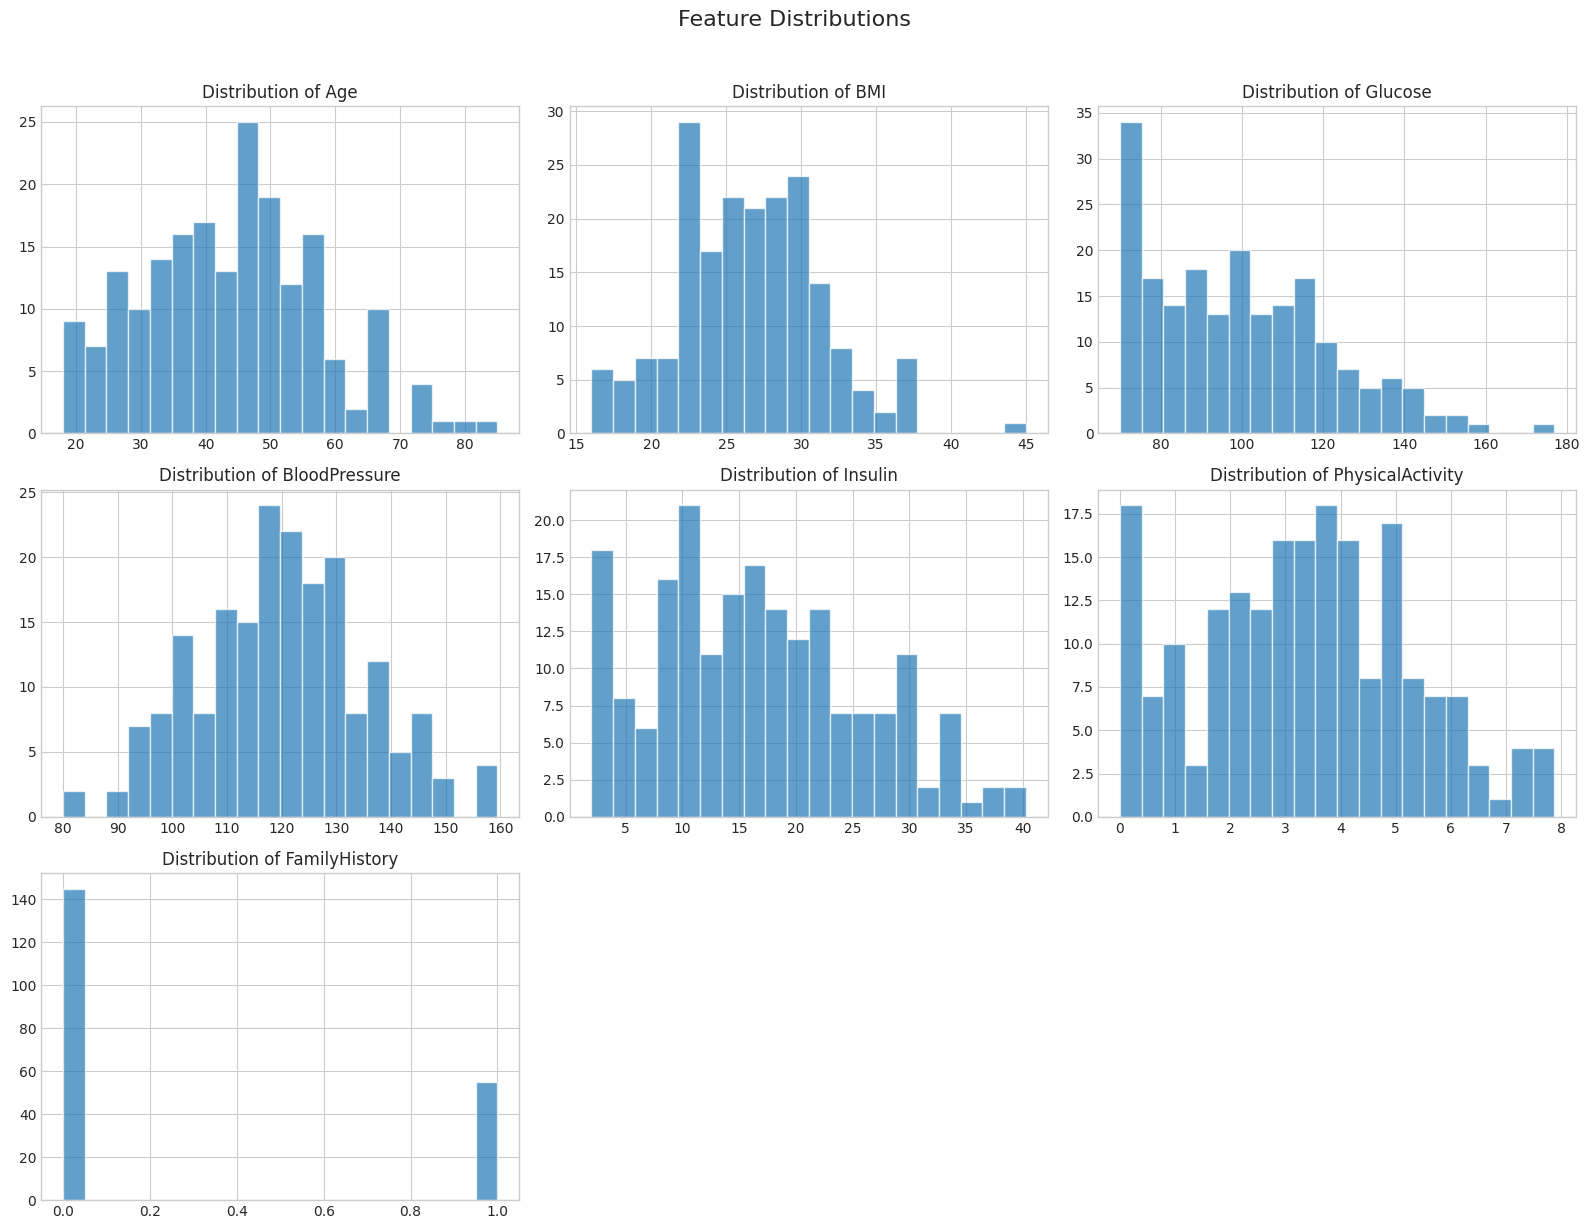

In [10]:
# 1. Histograms for each feature
plt.figure(figsize=(16, 12))

for i, column in enumerate(df.columns[:-1]):  # Exclude the target variable
    plt.subplot(3, 3, i+1)
    plt.hist(df[column].dropna(), bins=20, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.suptitle('Feature Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Given the dataset generation parameters, we know the ranges for the features:

> Age ranges 18 to 85; center 50

> BMI ranges 16 to 45; center 26

> Glucose ranges 70 to 200; center at around 100

> BP ranges 80 to 180; center 115

> Insulin ranges 2 to 50; center 17

> Physical Activity ranges 2 to 50; center 3.5

> Family history of diabetes has the values 0 and 1 (0 == false; 1 == true) with 30% of participants having a family history of diabetes

It appears Age, BMI, BP, Insulin, and Phys activity are roughly normal with centers at the center of their respective ranges.

Glucose is right skewed, with a majority of patients under the center.

Family history is imbalanced, but that is to be expected because of the generation method. Though, most people probably don't have a family history anyways.

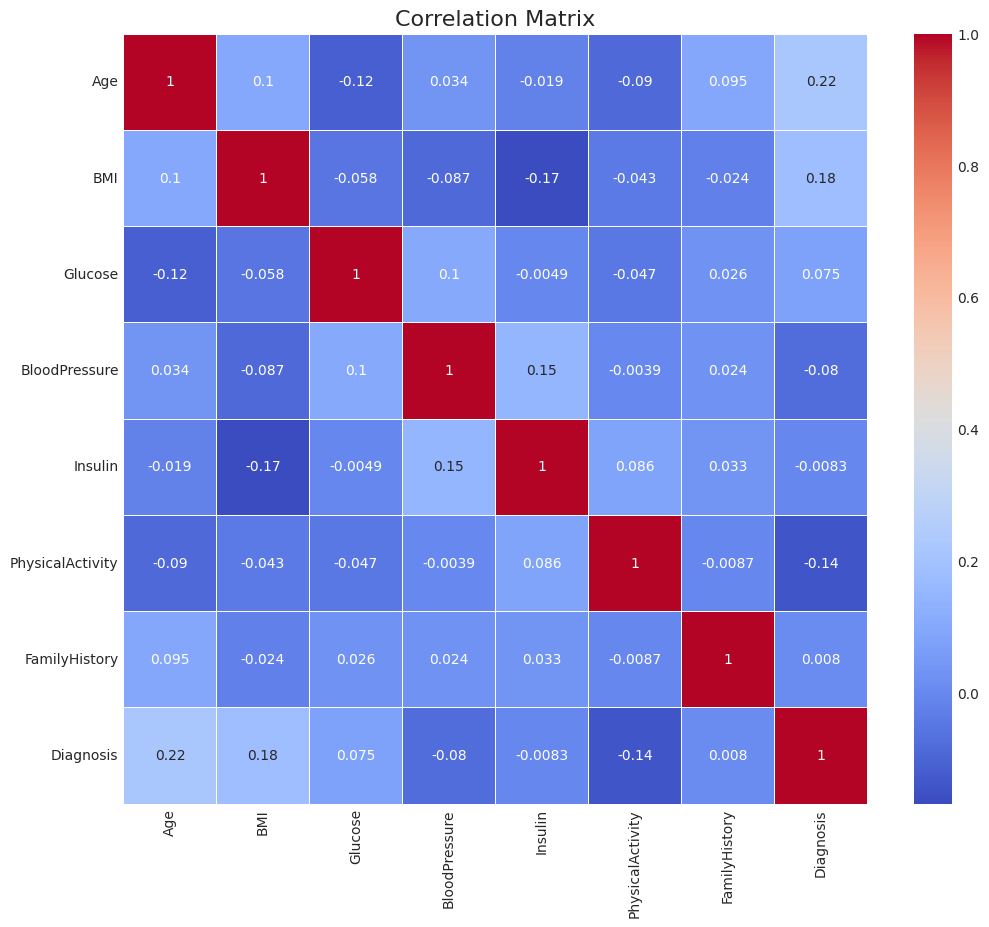

In [11]:
# 2. Correlations between features
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Nothing imediately jumps out as hyper correlated. There are some interesting correlations between features. Insulin and BMI are negatively correlated, diagnosis and phys activity are negatively correalted, glucose and age are negatively correlated.

Diagnosis and age and Diagnosis and BMI are rather positively correlated in comparison to the other features. Insulin and BP are pretty positively correlated.

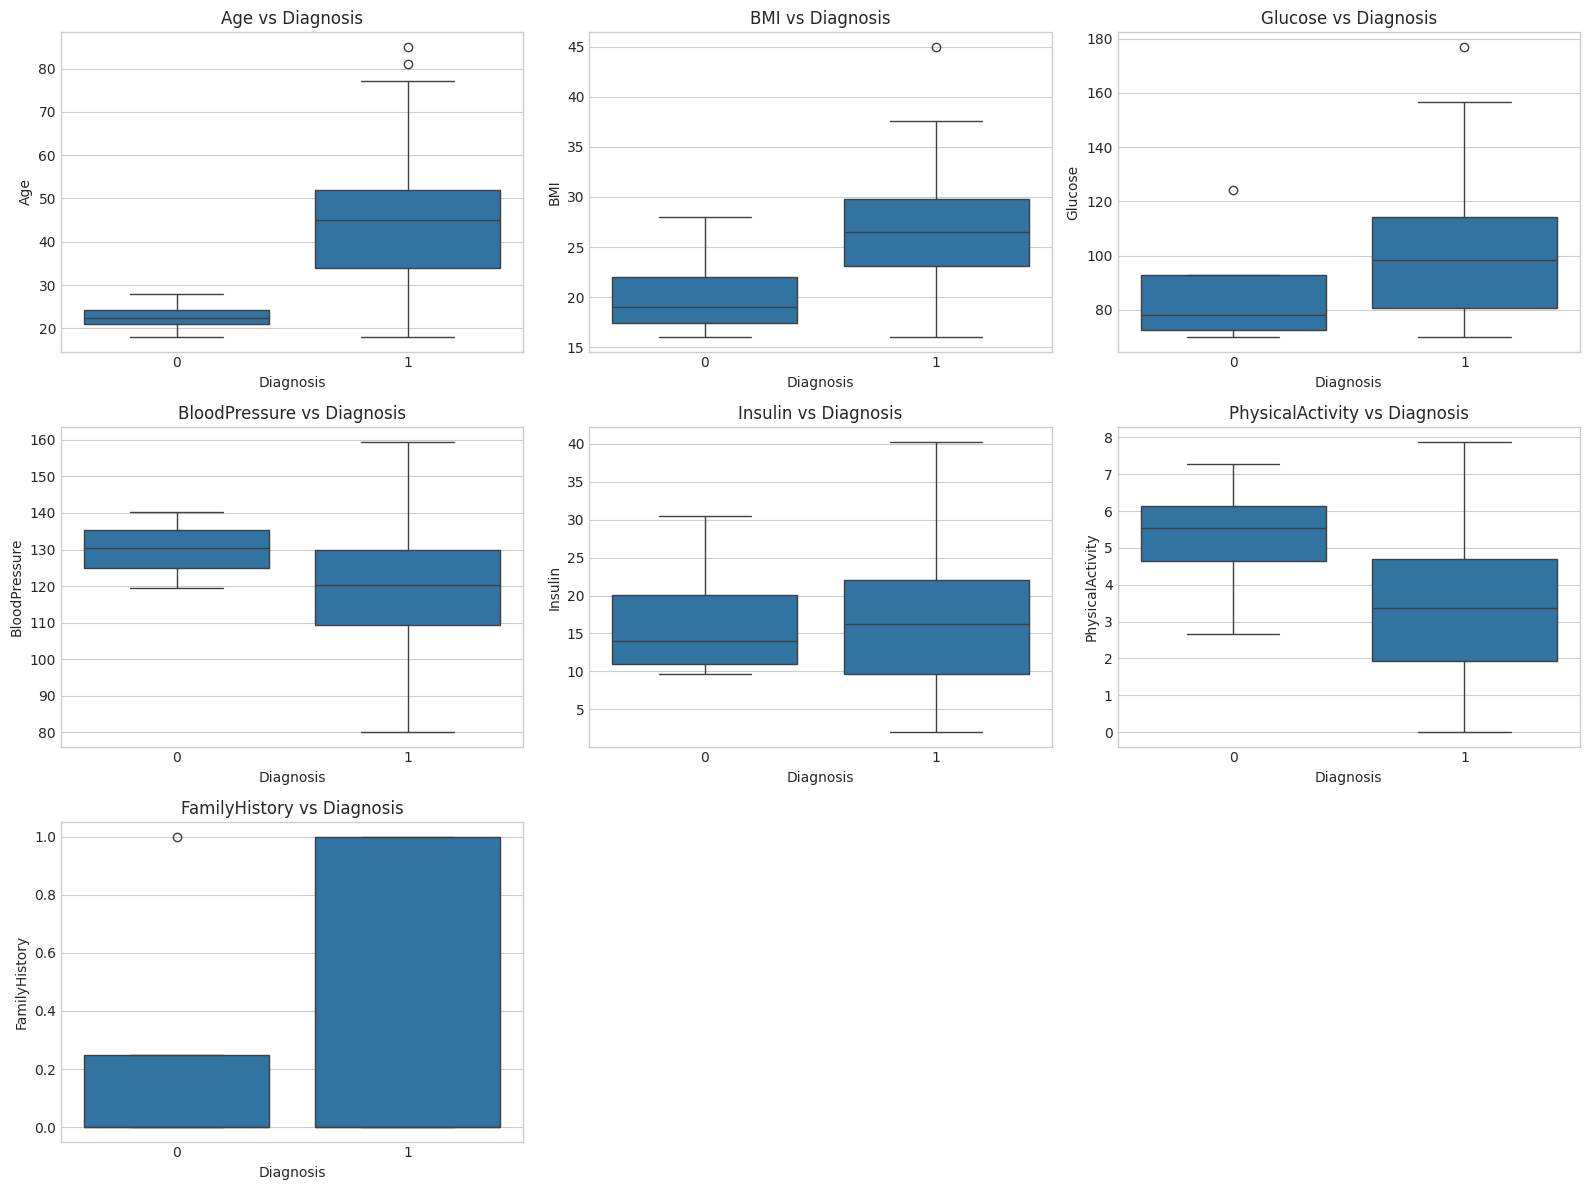

In [12]:
# 3. Box plots to identify outliers and see relationship with target
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns[:-1]):  # Exclude the target variable
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Diagnosis', y=column, data=df)
    plt.title(f'{column} vs Diagnosis')
plt.tight_layout()
plt.show()

There are outliers in the diabetic group of Age, BMI, and Glucose.
There are outliers in both groups of glucose levels.
There are outliers in people who have a family history of diabetes but do not have diabetes, meaning it is rare to have a history of diabetes but not to have diabetes

1. Which health metrics are most strongly associated with diabetes risk?

> When comparing the features over the Diagnosis, there seems to be a large difference in the median between age and diagnosis. There also seems to be a big difference in median between BMI and diagnosis and Phys activity and diagnosis.

> It seems like FamilyHistory and Diagnosis has a correlation as family history == 1 and diagnosis == 1 doesn't have outliers in that bar?

> Glucose and Diagnosis and BP and diagnosis seem related, but do not exhibit such a large change in median as the before mentioned corelations.

> Insulin and Diagnosis doesn't have a large change in median between diagnoeses, but positive diagnoses seem to have a larger spread in insulin levels; I think this may be due to diabetes related insulin spikes and requiring shots of insulin to bring down glucose levels?

> It seems Younger people are not so likely to have diabetes, higher BMI's are correlated with diabetes, higher glucose levels are correlated with diabetes, higher physical activity levels are correlated with not having diabetes.

Overall I think these trends follow the correlation matrix, so the health metrics most associated with diabetes risk are as follows:

1. Age
2. BMI
3. Physical activity
4. BP
5. Glucose

With insulin and family history not having such a strong correlation value or visual differentiation

## Part 2: Data Preprocessing

Now that we've explored our data, let's preprocess it for modeling.

In [13]:
print("Data Preprocessing:")
print("-----------------")

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Data Preprocessing:
-----------------

Missing Values:
Age                 4
BMI                 4
Glucose             1
BloodPressure       4
Insulin             2
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64


### Handling Missing Values

We need to handle these missing values before proceeding with modeling. Let's use a simple strategy of filling missing values with the median for numerical features.

In [14]:
'''# Strategy 1: Fill missing values with the median (for numerical features)
df_cleaned = df.copy()
for column in df_cleaned.columns[:-1]:  # Exclude the target variable
    if df_cleaned[column].isnull().sum() > 0:
        median_value = df_cleaned[column].median()
        df_cleaned[column].fillna(median_value, inplace=True)

print("\nMissing Values after filling with median:")
print(df_cleaned.isnull().sum())

# Check for data types
print("\nData Types:")
print(df_cleaned.dtypes)'''

'# Strategy 1: Fill missing values with the median (for numerical features)\ndf_cleaned = df.copy()\nfor column in df_cleaned.columns[:-1]:  # Exclude the target variable\n    if df_cleaned[column].isnull().sum() > 0:\n        median_value = df_cleaned[column].median()\n        df_cleaned[column].fillna(median_value, inplace=True)\n\nprint("\nMissing Values after filling with median:")\nprint(df_cleaned.isnull().sum())\n\n# Check for data types\nprint("\nData Types:")\nprint(df_cleaned.dtypes)'

In [15]:
### Handling Missing Values (Alternative Strategies)

# Strategy 2: Imputation using K-Nearest Neighbors (KNN)
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5) # You can adjust the number of neighbors
df_cleaned_knn = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("\nMissing Values after KNN imputation:")
print(df_cleaned_knn.isnull().sum())


# Strategy 3: Drop rows with missing values
# df_cleaned_dropped = df.dropna()

# print("\nShape after dropping rows with missing values:", df_cleaned_dropped.shape)


Missing Values after KNN imputation:
Age                 0
BMI                 0
Glucose             0
BloodPressure       0
Insulin             0
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64


Because there are not many missing values, I chose to try to fill them in with knn instead of filling them in with the median. I believe because some of the data that is attempted to be filled in differs accross being diagnosed positive or negative, it may make sense to try to use knn to approximate missing values for consistancy sake


### Feature Scaling and Train-Test Split

Now let's prepare our data for modeling by splitting it into training and testing sets and scaling the features.

In [16]:
df_cleaned = df_cleaned_knn

In [17]:
# Feature scaling (important for SVM)
# Normalize features to have similar scales which helps SVM perform better
X = df_cleaned.drop('Diagnosis', axis=1)  # Features
y = df_cleaned['Diagnosis']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #150:50 test:train split

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Feature scaling is very important for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data


Training set size: (150, 7)
Testing set size: (50, 7)


In [18]:
#recombine data to check for data balance in diagnosis
train_comb = pd.concat([X_train, y_train], axis=1)
train_comb.head()

print(train_comb['Diagnosis'].value_counts)

<bound method IndexOpsMixin.value_counts of 114    1.0
173    1.0
5      1.0
126    1.0
117    1.0
      ... 
106    1.0
14     1.0
92     1.0
179    1.0
102    1.0
Name: Diagnosis, Length: 150, dtype: float64>


## Part 3: Support Vector Machine (SVM)

Now let's implement and evaluate a Support Vector Machine classifier.

### SVM with Linear Kernel

SVMs don't handle imbalanced data
Therefore it may be appropriate to balance the training data by either getting rid of additional negative diagnoses or by synthesizing data.

Don't SVMs also need cross validation???

In [19]:
from sklearn.model_selection import cross_val_score, KFold

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
#Apply SMOTE to SVM

#balance the minority class
smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train[y_train == 0])-1)) #set k_neighbors to be at most the size of the minority class - 1
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# Train an SVM classifier with a linear kernel first
svm_linear = SVC(kernel='linear', random_state=42, class_weight={0:1,1:50}) #class 1 is 50 times more likely than class 0
svm_linear.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_svm_linear = svm_linear.predict(X_test_scaled)

# Evaluate the model
print("SVM (Linear Kernel) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_linear) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_linear))

SVM (Linear Kernel) Results:
Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


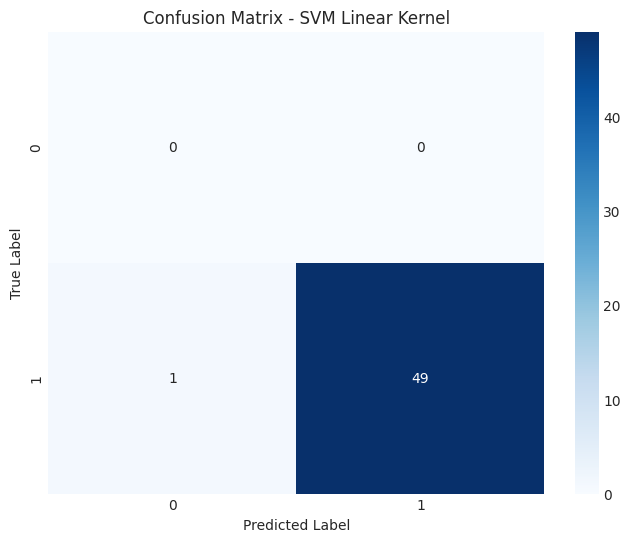

In [22]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm_svm_linear = confusion_matrix(y_test, y_pred_svm_linear)
sns.heatmap(cm_svm_linear, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Linear Kernel')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
import sklearn as sk

In [24]:
#implement cv= 5; try class weight

kf = sk.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train an SVM classifier with a linear kernel first
svm_linear = SVC(kernel='linear', random_state=42, class_weight={0:1,1:50}) #try class weight

scores = cross_val_score(svm_linear, X_train_scaled, y_train, cv=kf)

print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation score:", np.std(scores))

svm_linear.fit(X_train_scaled, y_train)

y_pred = svm_linear.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))


Cross-validation scores: [1.         0.96666667 0.96666667 0.93333333 0.96666667]
Mean cross-validation score: 0.9666666666666668
Standard deviation of cross-validation score: 0.02108185106778919
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Well this model obviously doesnt work. There are cases of both classes in the test set and this only found one class, positive for all 50 samples which is incorrect.

In [25]:
#implement cv= 5; try smote

# Train an SVM classifier with a linear kernel first
svm_linear = SVC(kernel='linear', random_state=42)

scores = cross_val_score(svm_linear, X_train_resampled, y_train_resampled, cv=kf)

print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation score:", np.std(scores))

svm_linear.fit(X_train_resampled, y_train_resampled)

y_pred = svm_linear.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [1.         0.98305085 1.         1.         1.        ]
Mean cross-validation score: 0.9966101694915255
Standard deviation of cross-validation score: 0.006779661016949134
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


I believe the original model from the original code to possibly be over fitted. While it predicted the cases correctly, it seems to be a wild chance. What I mean by a wild chance, is it only has a 2% possibility to have any false classifications when only 1/50 cases in the test set is negative for diabetes.

> I believe applying SMOTE has balanced the target variable imbalance, which makes using a SVM feasible. However, due to the lack of data of the minority class, KNN is likely only generating noise.

I still believe this model to not be the best choice for this application.

### SVM with RBF Kernel

Let's try a different kernel (RBF - Radial Basis Function) which can capture non-linear relationships in the data.

In [26]:
'''#implement cv=3

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Train an SVM classifier with a linear kernel first
svm_rbf = SVC(kernel='rbf', random_state=42)

scores = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=kf)

print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation score:", np.std(scores))'''

'#implement cv=3\n\nkf = KFold(n_splits=3, shuffle=True, random_state=42)\n\n# Train an SVM classifier with a linear kernel first\nsvm_rbf = SVC(kernel=\'rbf\', random_state=42)\n\nscores = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=kf)\n\nprint("Cross-validation scores:", scores)\n\n# Print the mean and standard deviation of the scores\nprint("Mean cross-validation score:", np.mean(scores))\nprint("Standard deviation of cross-validation score:", np.std(scores))'

In [27]:
# Try a different kernel (RBF - Radial Basis Function)
svm_rbf = SVC(kernel='rbf', random_state=42, class_weight={0:1,1:50}) #class 1 is 50 times more likely than class 0
svm_rbf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)

# Evaluate the model
print("SVM (RBF Kernel) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_rbf) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_rbf))

SVM (RBF Kernel) Results:
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [28]:
#Precision and recall should be on the opposite ends of a coin, unless all target variable cases are one value; in that case, it is likely the case that this SVM is misclassifying all cases as positive for diabetes

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


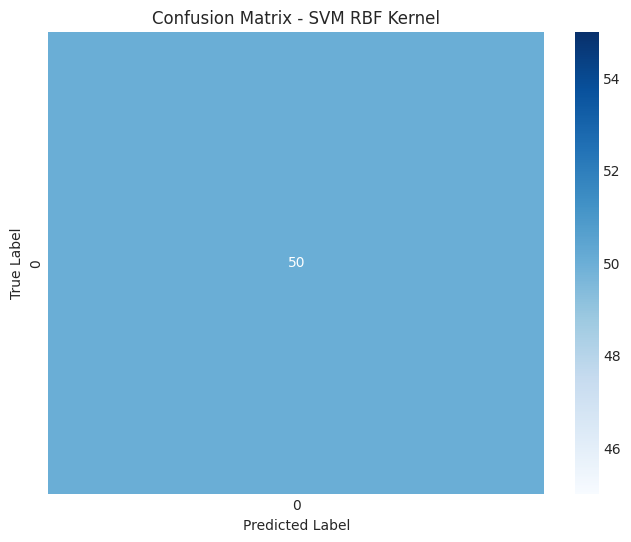

In [29]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)
sns.heatmap(cm_svm_rbf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM RBF Kernel')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
#implement cv= 5; try smote

# Train an SVM classifier with a linear kernel first
svm_rbf = SVC(kernel='rbf', random_state=42)

scores = cross_val_score(svm_rbf, X_train_resampled, y_train_resampled, cv=kf)

print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation score:", np.std(scores))

svm_rbf.fit(X_train_resampled, y_train_resampled)

y_pred = svm_rbf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.98305085 0.98305085 1.         0.98275862 1.        ]
Mean cross-validation score: 0.9897720631209819
Standard deviation of cross-validation score: 0.008351757184288128
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
#Use gridsearch for optimal SVM parameters
# I left in all features for now to see how it works

from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {
'C': [0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1],
'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

svm = SVC()

# Set up grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [32]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print("Best Parameters:", best_params)
print("Classification Report:\n", classification_report(y_test, y_pred))


print("Best score:\n", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Best score:
 0.9966101694915255


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Can we build an accurate model to predict diabetes risk using patient health data?

> I believe this dataset is unsuitable for an svm. Even after assigning class weights and applying SMOTE, the f1 score was near 1 and the training set's target data was heavily imbalanced.

> It seems assigning class weights for linear and RBF to be ineffective, however SMOTE was effective in training the model to make predictions for both classes.

## Part 4: Decision Tree Classifier

Now let's implement and evaluate a Decision Tree classifier.

In [33]:
# Train a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)  # Note: Decision Trees don't usually require scaled features

# Make predictions
y_pred_dt = dt.predict(X_test)

# Evaluate the model
print("Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Results:
Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


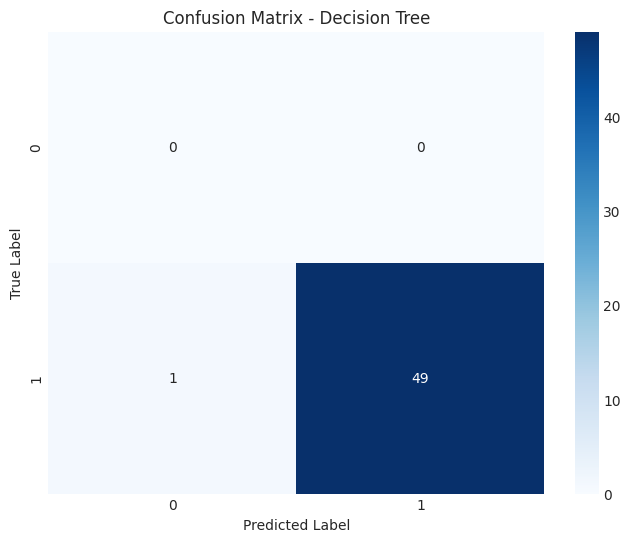

In [34]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Visualizing the Decision Tree

One of the advantages of Decision Trees is their interpretability. Let's visualize the tree structure.

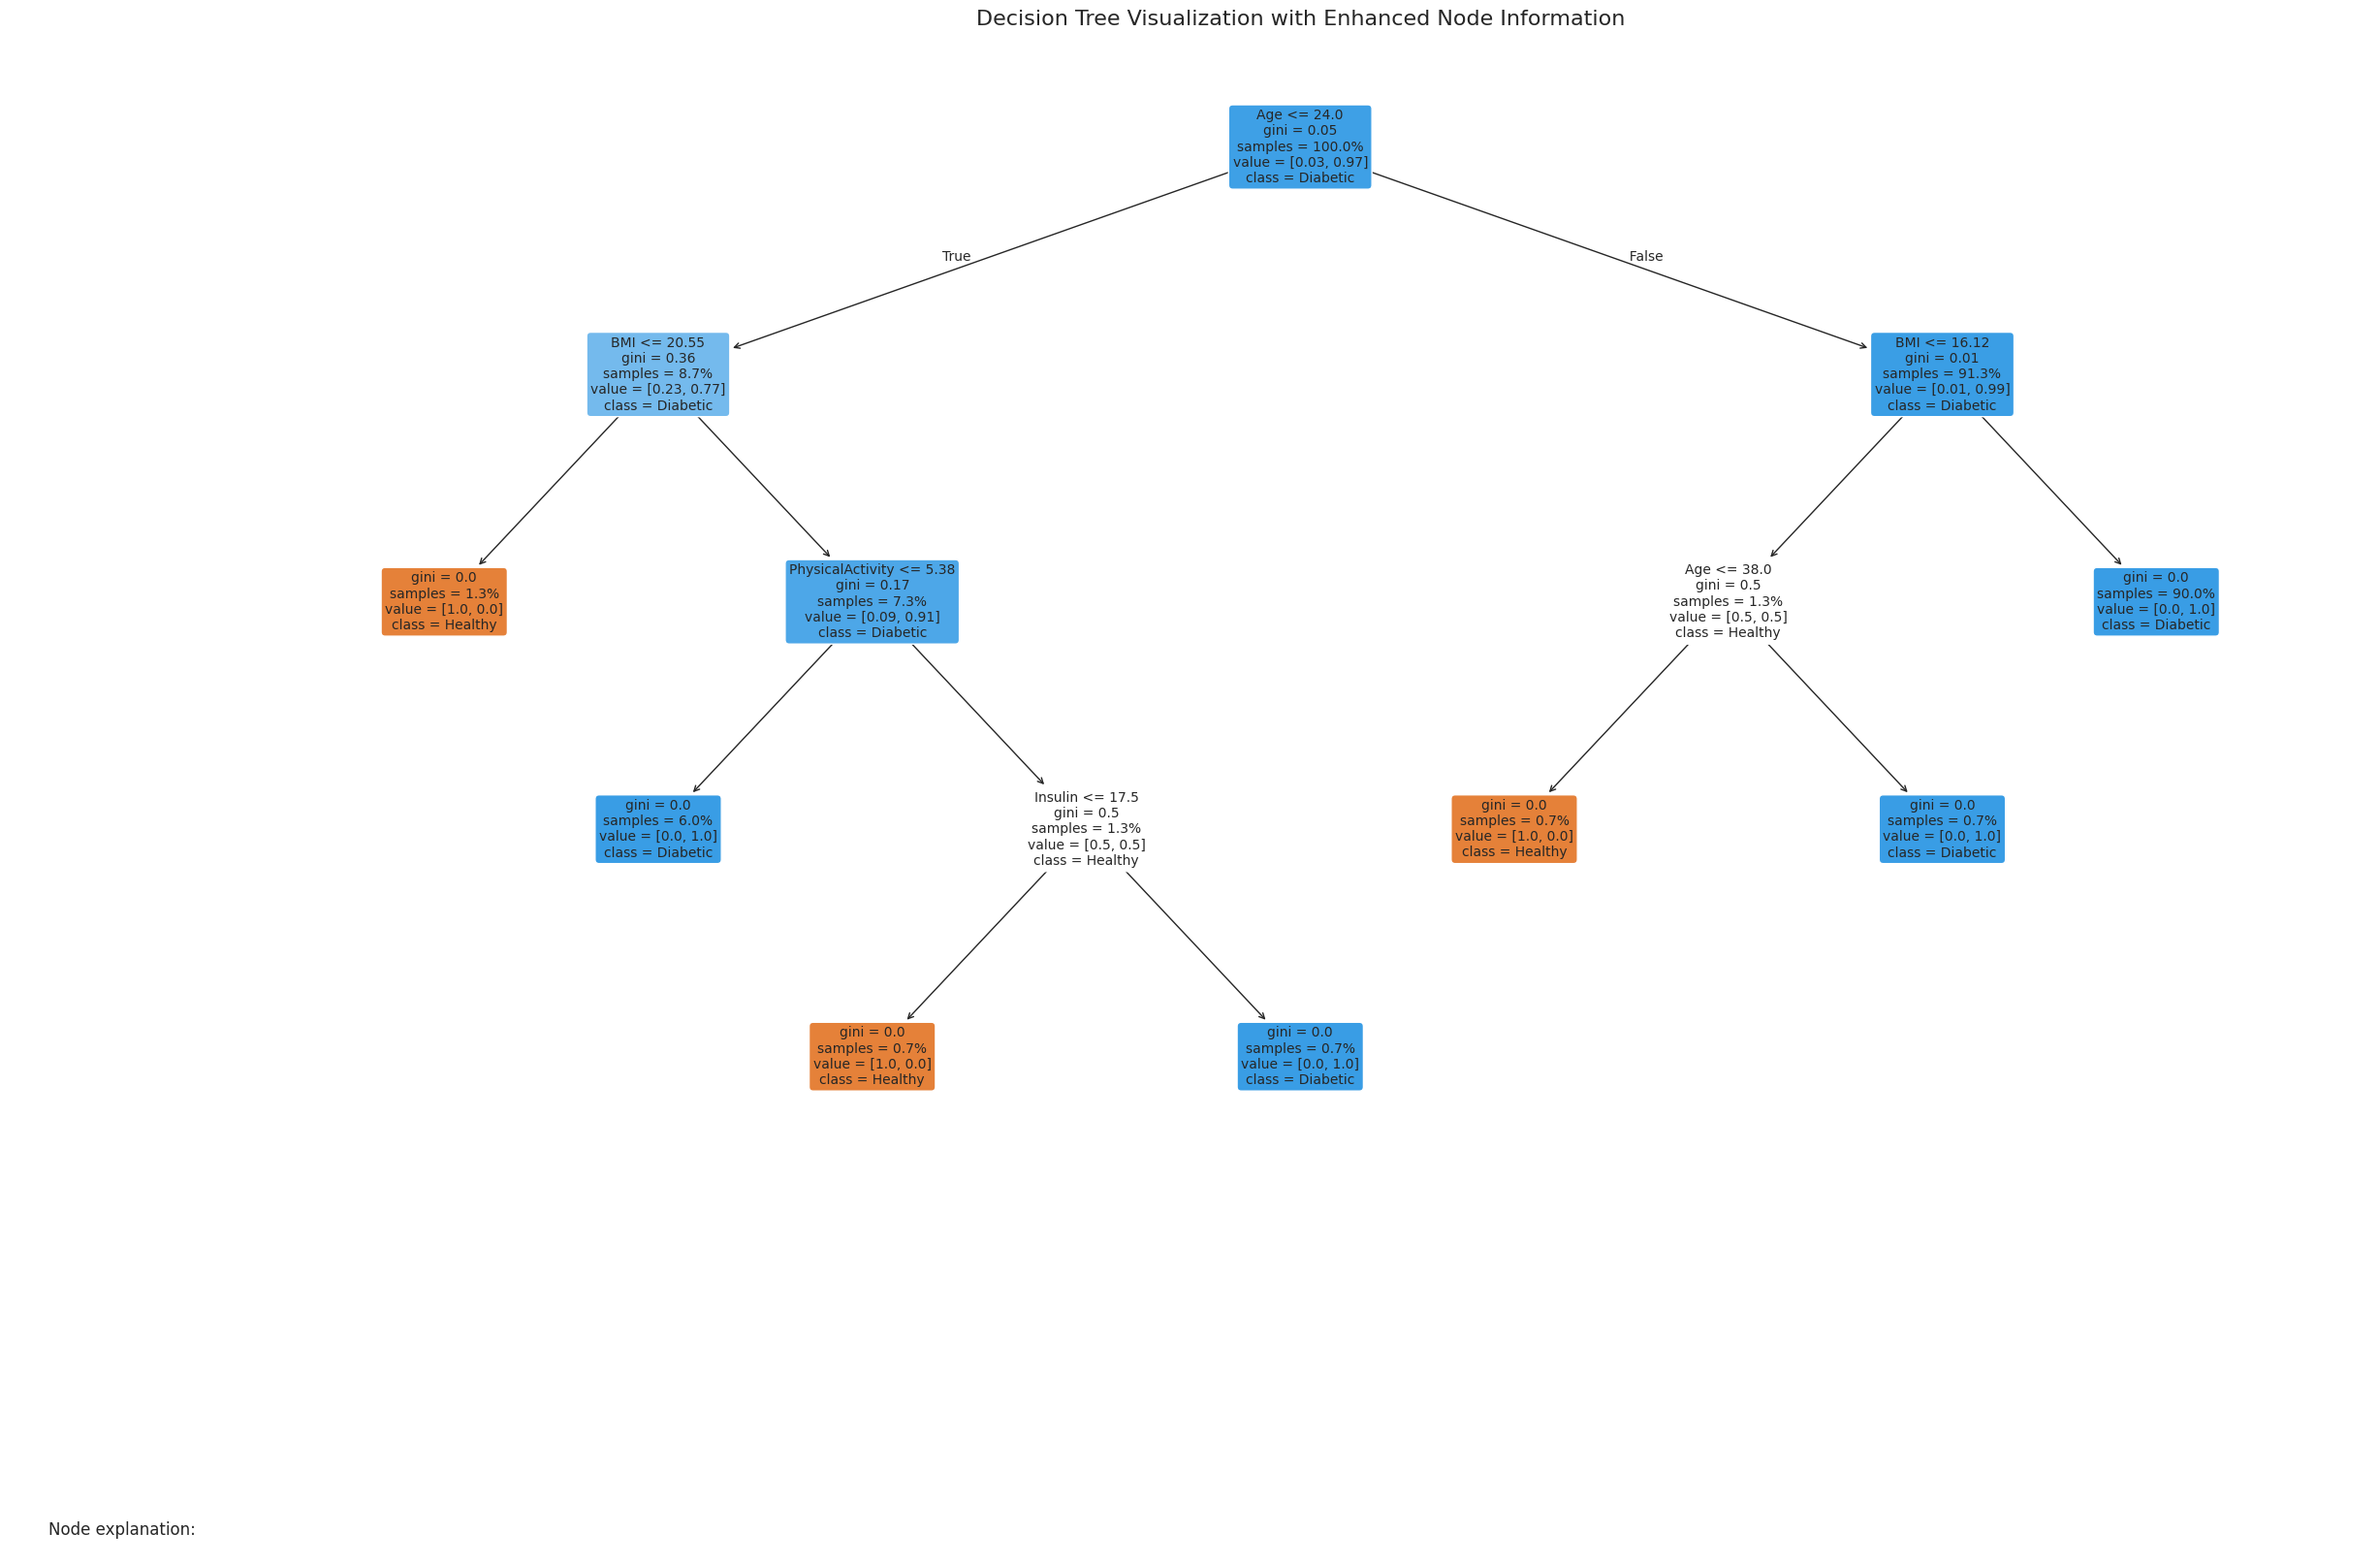

How to interpret this Decision Tree:
1. Start at the top (root) node and follow the branches based on the feature conditions
2. Each internal node shows a decision based on a feature value
3. The 'gini' value indicates the impurity of the node (0 = pure, higher values = more mixed)
4. The sample values show the distribution of classes at that node
5. Leaf nodes (at the bottom) represent the final classification
6. The color indicates the majority class (blue = Healthy, orange = Diabetic)


In [35]:
# Decision Tree visualization with clearer node information as we saw in the class example
plt.figure(figsize=(25, 15))  # Larger figure size for better readability

# Create the tree visualization with more detailed parameters
tree_viz = tree.plot_tree(dt,
                         feature_names=X.columns,
                         class_names=['Healthy', 'Diabetic'],
                         filled=True,
                         rounded=True,
                         precision=2,  # Show 2 decimal places for values
                         proportion=True,  # Show proportions instead of counts
                         fontsize=10)  # Larger font size

# Add text annotations to explain the node elements
plt.annotate('Node explanation:', xy=(0.02, 0.02), xycoords='figure fraction', fontsize=12)
plt.annotate('- Top value: Feature and threshold for splitting', xy=(0.02, -0.01), xycoords='figure fraction', fontsize=10)
plt.annotate('- Middle value: Gini impurity (lower = more homogeneous)', xy=(0.02, -0.03), xycoords='figure fraction', fontsize=10)
plt.annotate('- Bottom values: Sample distribution (Healthy/Diabetic)', xy=(0.02, -0.05), xycoords='figure fraction', fontsize=10)
plt.annotate('- Blue nodes: Majority Healthy, Orange nodes: Majority Diabetic', xy=(0.02, -0.07), xycoords='figure fraction', fontsize=10)

plt.title('Decision Tree Visualization with Enhanced Node Information', fontsize=16)
plt.tight_layout()
plt.show()

# Add a more detailed explanation of how to interpret the tree
print("How to interpret this Decision Tree:")
print("1. Start at the top (root) node and follow the branches based on the feature conditions")
print("2. Each internal node shows a decision based on a feature value")
print("3. The 'gini' value indicates the impurity of the node (0 = pure, higher values = more mixed)")
print("4. The sample values show the distribution of classes at that node")
print("5. Leaf nodes (at the bottom) represent the final classification")
print("6. The color indicates the majority class (blue = Healthy, orange = Diabetic)")


### Feature Importance in Decision Tree

Let's examine which features the Decision Tree considers most important for classification.

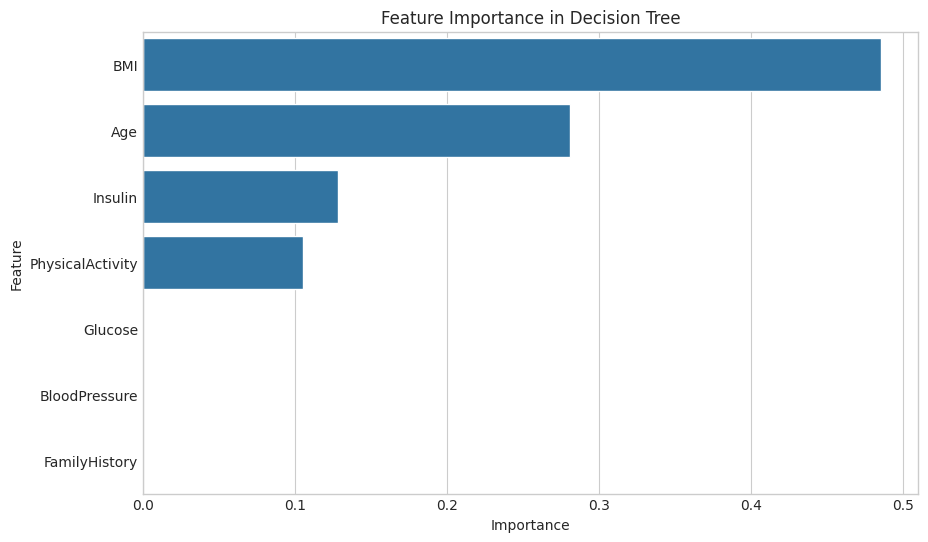

In [36]:
# Look at feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Decision Tree')
plt.show()

### Pruned Decision Tree

Decision Trees can easily overfit the training data. Let's try a pruned version with controlled depth and minimum samples for splitting.

In [37]:
# Try a decision tree with different parameters
dt_pruned = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
dt_pruned.fit(X_train, y_train)

# Make predictions
y_pred_dt_pruned = dt_pruned.predict(X_test)

# Evaluate the model
print("Pruned Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_pruned) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_pruned))

Pruned Decision Tree Results:
Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


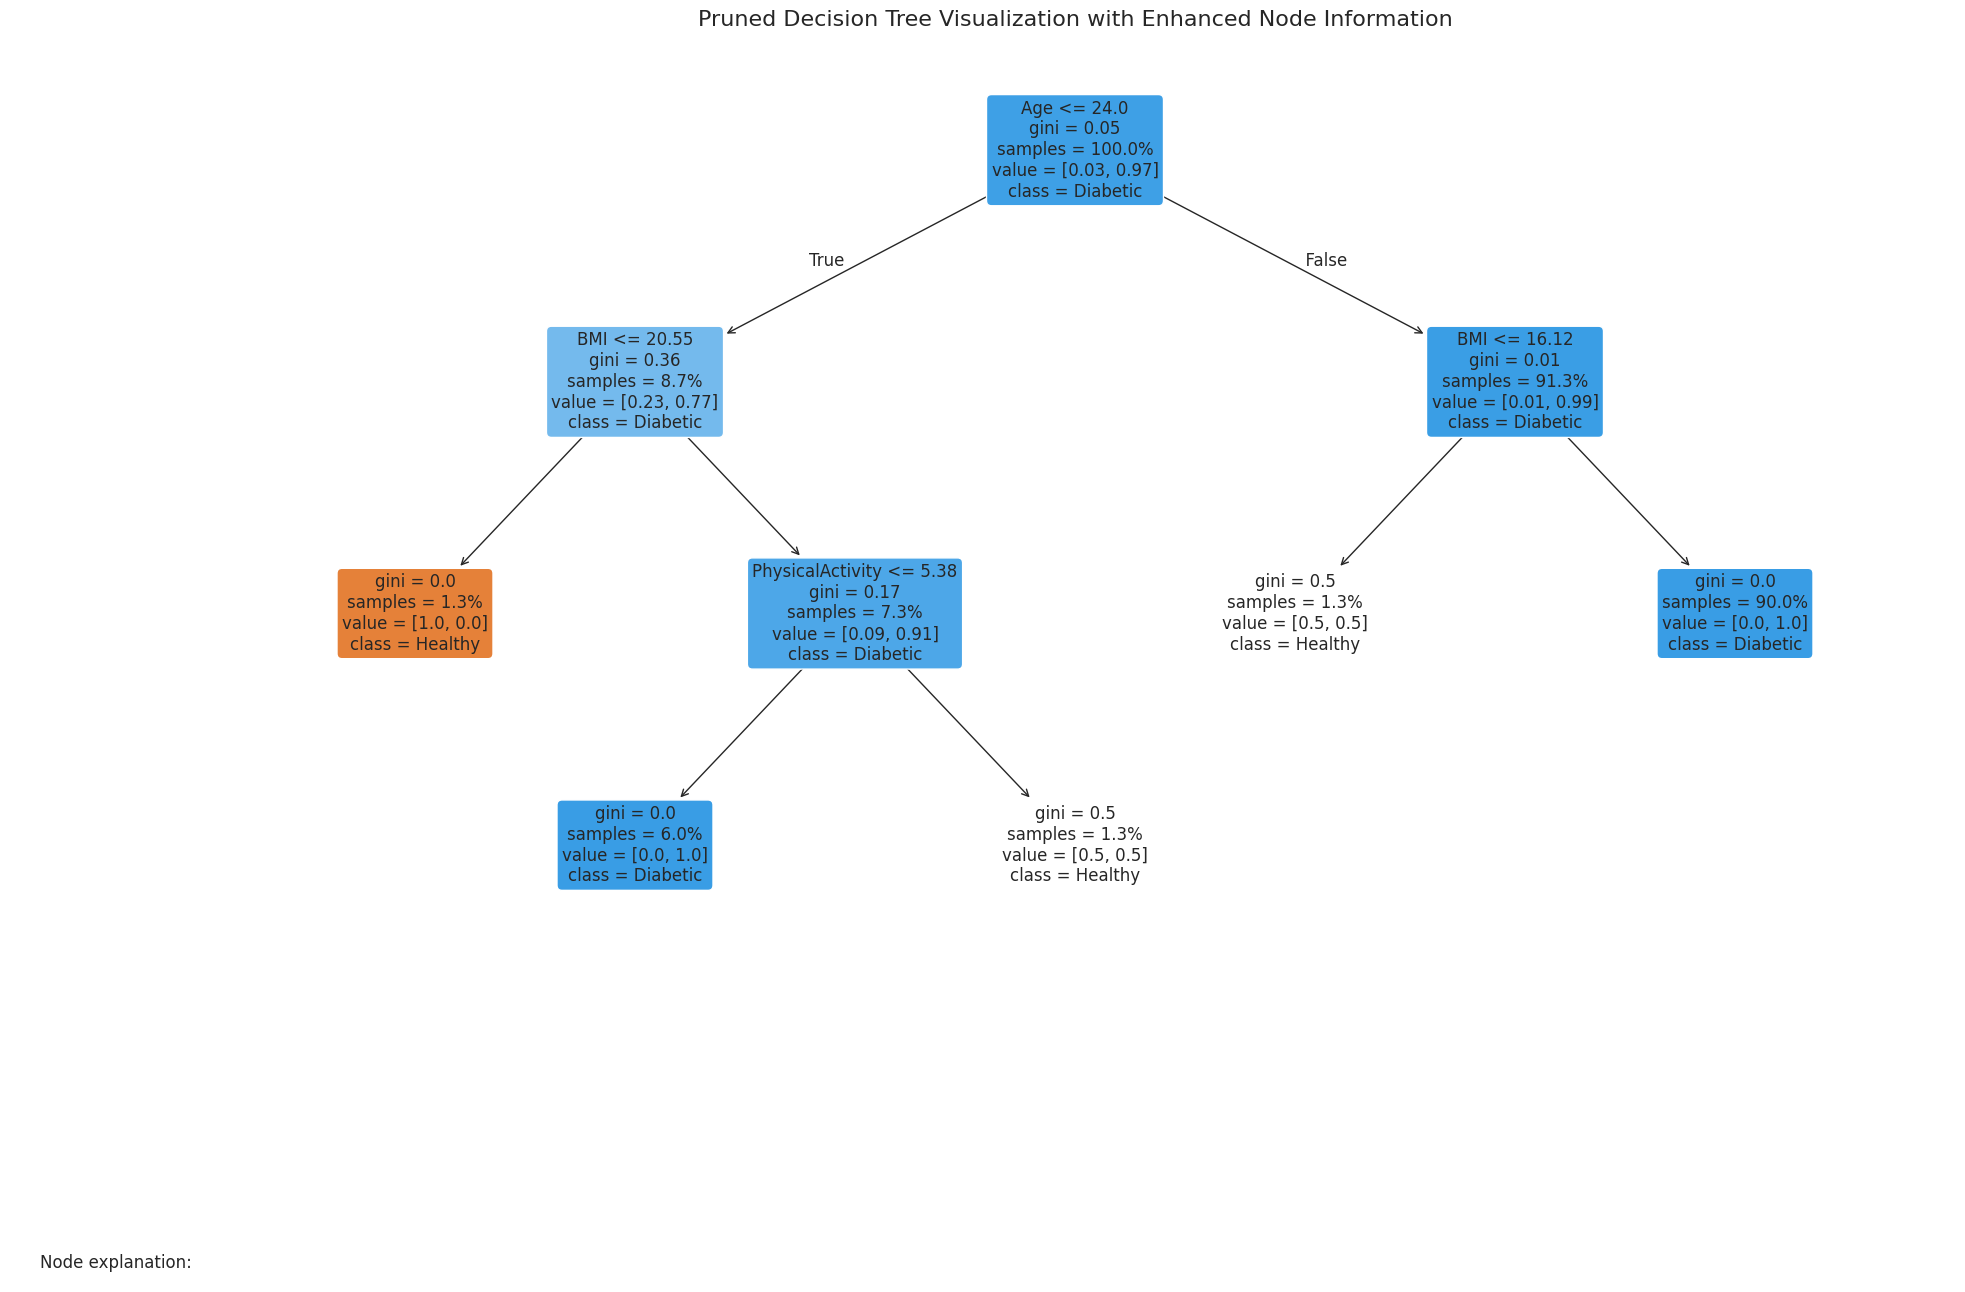

Unpruned tree has 7 leaves and max depth of 4
Pruned tree has 5 leaves and max depth of 3

Note how pruning reduces complexity while maintaining reasonable performance.


In [38]:
# Enhanced Pruned Decision Tree visualization with clearer node information
plt.figure(figsize=(20, 12))  # Adjusted size for the smaller pruned tree

# Create the tree visualization with more detailed parameters
tree_viz = tree.plot_tree(dt_pruned,
                         feature_names=X.columns,
                         class_names=['Healthy', 'Diabetic'],
                         filled=True,
                         rounded=True,
                         precision=2,  # Show 2 decimal places for values
                         proportion=True,  # Show proportions instead of counts
                         fontsize=12)  # Larger font size for better readability

# Add text annotations to explain the node elements
plt.annotate('Node explanation:', xy=(0.02, 0.02), xycoords='figure fraction', fontsize=12)
plt.annotate('- Top value: Feature and threshold for splitting', xy=(0.02, -0.01), xycoords='figure fraction', fontsize=10)
plt.annotate('- Middle value: Gini impurity (lower = more homogeneous)', xy=(0.02, -0.03), xycoords='figure fraction', fontsize=10)
plt.annotate('- Bottom values: Sample distribution (Healthy/Diabetic)', xy=(0.02, -0.05), xycoords='figure fraction', fontsize=10)
plt.annotate('- Blue nodes: Majority Healthy, Orange nodes: Majority Diabetic', xy=(0.02, -0.07), xycoords='figure fraction', fontsize=10)

plt.title('Pruned Decision Tree Visualization with Enhanced Node Information', fontsize=16)
plt.tight_layout()
plt.show()

# Compare the complexity of the pruned vs. unpruned tree
print(f"Unpruned tree has {dt.get_n_leaves()} leaves and max depth of {dt.get_depth()}")
print(f"Pruned tree has {dt_pruned.get_n_leaves()} leaves and max depth of {dt_pruned.get_depth()}")
print("\nNote how pruning reduces complexity while maintaining reasonable performance.")


In [39]:
from sklearn.model_selection import StratifiedKFold

In [40]:
#try new parameters

# I did not balance the target variable because decision trees can generally handle imbalanced data

#define param grid

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1,2,3,4,5,6,7],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# cv = 4
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

#choose accuracy as the metric to identify the most performant model
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring='accuracy')

#train decision trees
grid_search.fit(X_train, y_train)  # Note: Decision Trees don't usually require scaled features

#find the best model and parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#test best model
y_pred = best_model.predict(X_test)
print("Best Parameters:", best_params)
print("Classification Report:\n", classification_report(y_test, y_pred))

#output results and best score
#print("Cross-validation results:\n", grid_search.cv_results_)
#print("Best score:\n", grid_search.best_score_)

'''# Make predictions
y_pred_dt = dt.predict(X_test)

# Evaluate the model
print("Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))'''

Best Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.49      0.49        50
weighted avg       1.00      0.98      0.99        50



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1344 fits failed out of a total of 3072.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
768 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ut

'# Make predictions\ny_pred_dt = dt.predict(X_test)\n\n# Evaluate the model\nprint("Decision Tree Results:")\nprint(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_dt))'

In [41]:
#try the model of best fit

#Best Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}

dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features='sqrt', min_samples_leaf=1, min_samples_split=2) #why is min samples per leaf = 2 the best found from gridsearchcv, when there is likely only one case where diabetes was negative in the test set; odd
dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test)


# Evaluate the model
print("GridSearch Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

GridSearch Decision Tree Results:
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



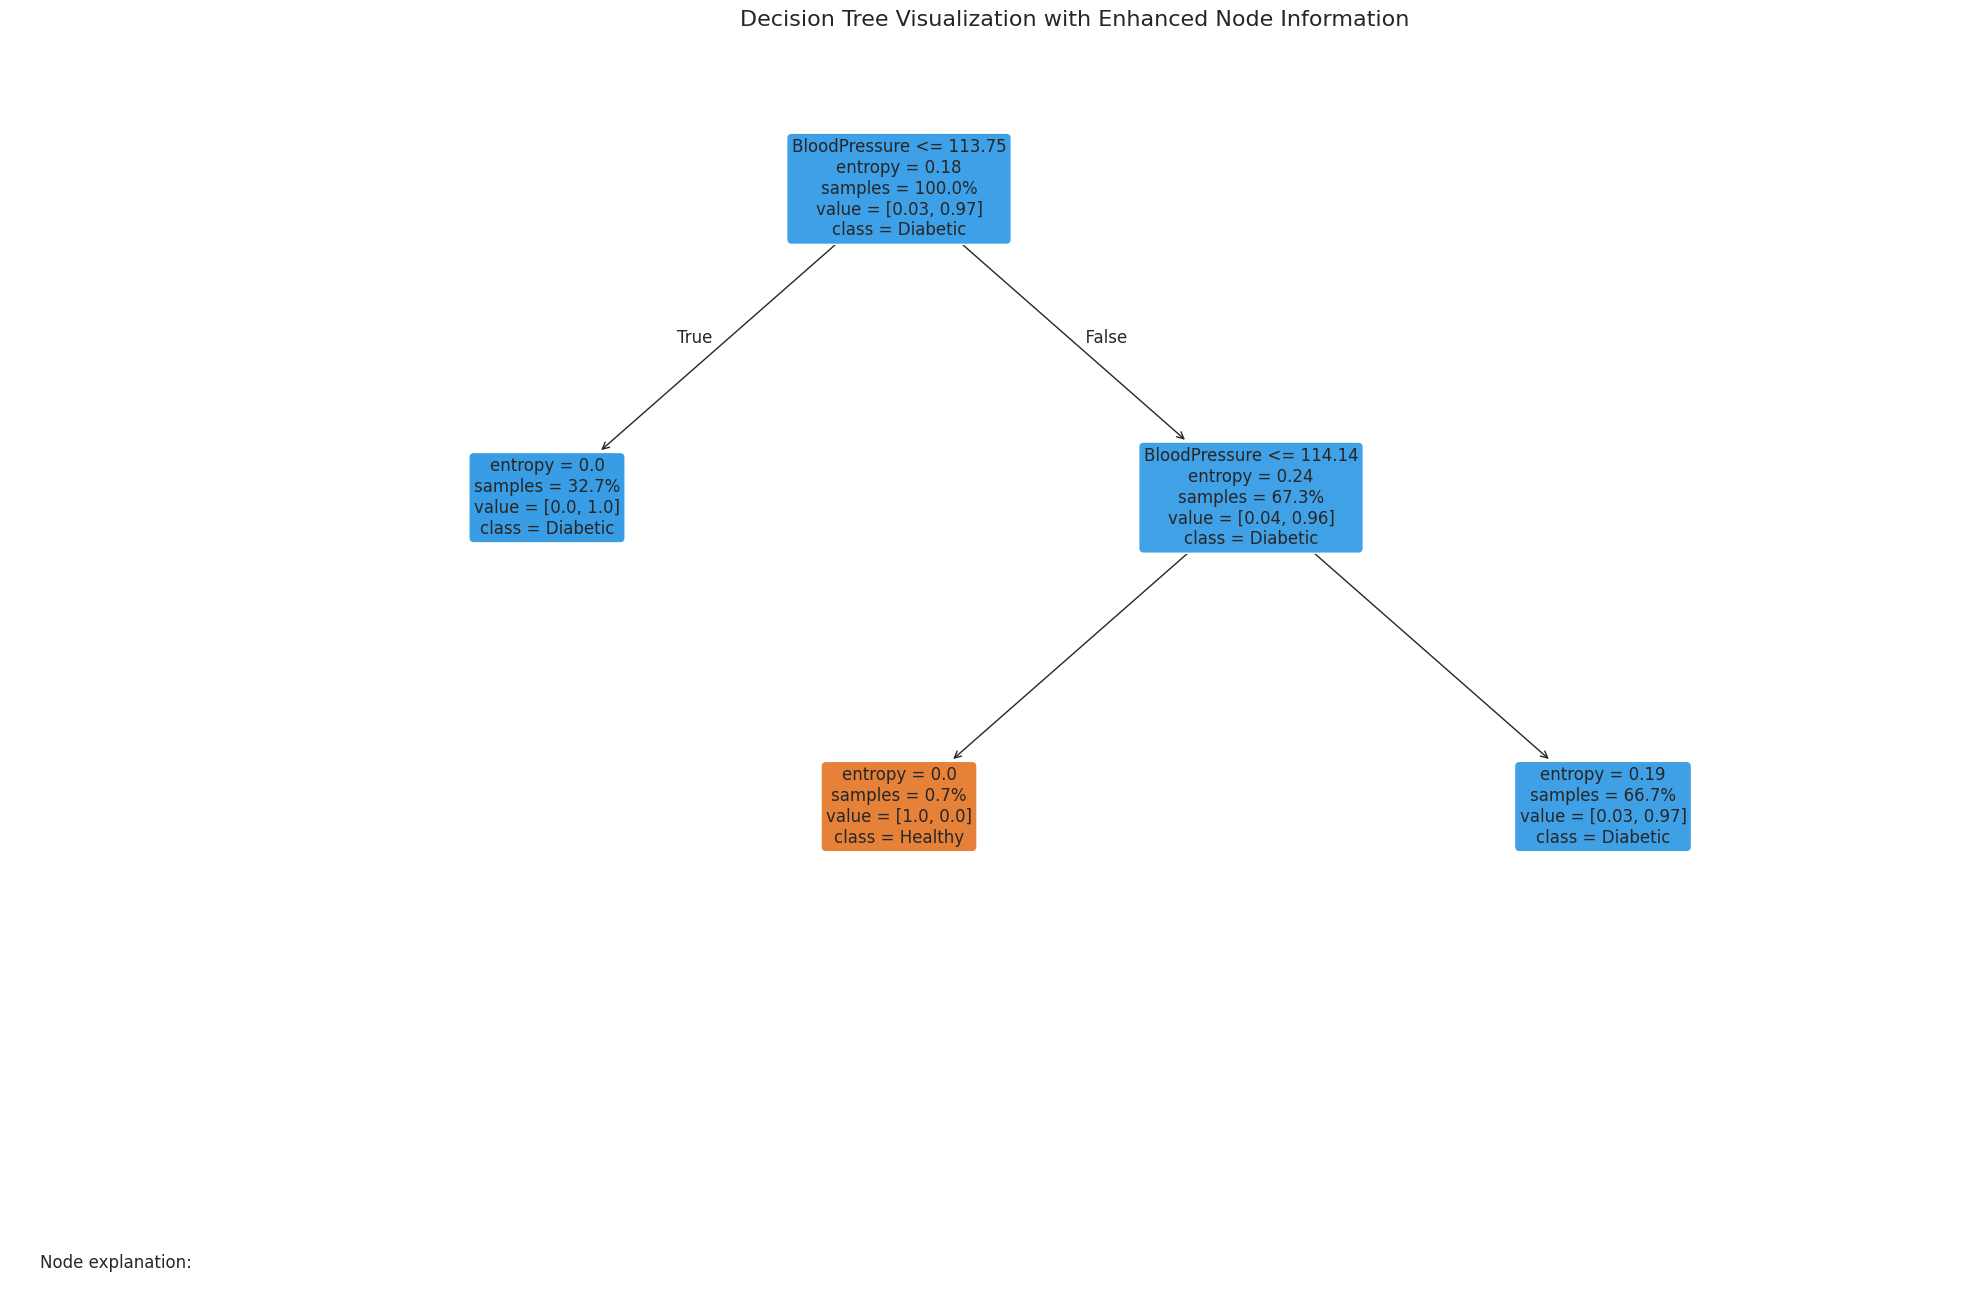

In [42]:
plt.figure(figsize=(20, 12))  # Adjusted size for the smaller pruned tree

# Create the tree visualization with more detailed parameters
tree_viz = tree.plot_tree(dt,
                         feature_names=X.columns,
                         class_names=['Healthy', 'Diabetic'],
                         filled=True,
                         rounded=True,
                         precision=2,  # Show 2 decimal places for values
                         proportion=True,  # Show proportions instead of counts
                         fontsize=12)  # Larger font size for better readability

# Add text annotations to explain the node elements
plt.annotate('Node explanation:', xy=(0.02, 0.02), xycoords='figure fraction', fontsize=12)
plt.annotate('- Top value: Feature and threshold for splitting', xy=(0.02, -0.01), xycoords='figure fraction', fontsize=10)
plt.annotate('- Middle value: Entropy', xy=(0.02, -0.03), xycoords='figure fraction', fontsize=10)
plt.annotate('- Bottom values: Sample distribution (Healthy/Diabetic)', xy=(0.02, -0.05), xycoords='figure fraction', fontsize=10)
plt.annotate('- Blue nodes: Majority Healthy, Orange nodes: Majority Diabetic', xy=(0.02, -0.07), xycoords='figure fraction', fontsize=10)

plt.title('Decision Tree Visualization with Enhanced Node Information', fontsize=16)
plt.tight_layout()
plt.show()

## Part 5: Comparison of Models

Now let's compare the performance of all the models we've built.

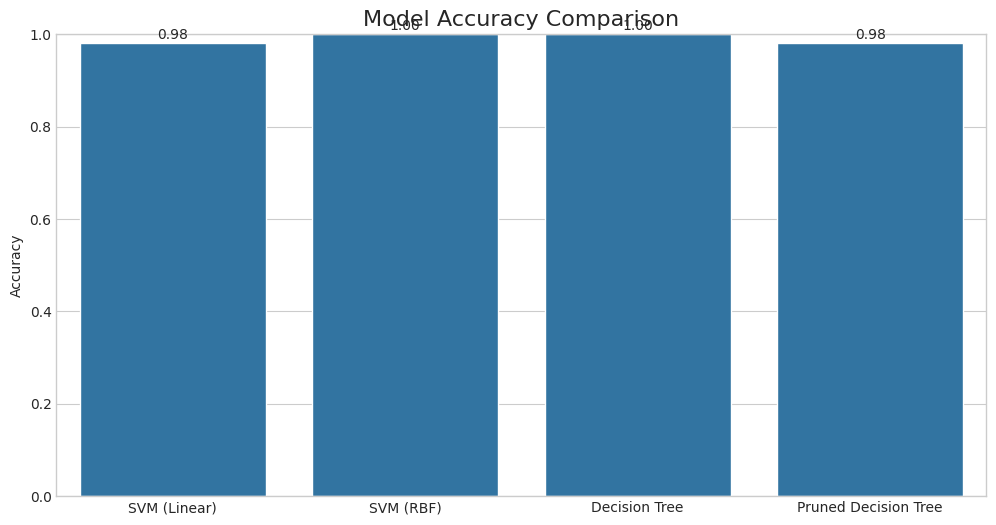


Accuracy Comparison:
SVM (Linear): 98.00%
SVM (RBF): 100.00%
Decision Tree: 100.00%
Pruned Decision Tree: 98.00%


In [43]:
models = ['SVM (Linear)', 'SVM (RBF)', 'Decision Tree', 'Pruned Decision Tree']
accuracies = [
    accuracy_score(y_test, y_pred_svm_linear),
    accuracy_score(y_test, y_pred_svm_rbf),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_dt_pruned)
]

plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center')
plt.show()

print("\nAccuracy Comparison:")
for model, acc in zip(models, accuracies):
    print(f"{model}: {acc * 100:.2f}%")

Which algorithm performs better for this task: Support Vector Machines or Decision Trees?

> The Linear SVM using SMOTE was able to predict both classes correctly, however due to the before mentioned issues with minority class size and the imbalance, I am hesitent to call it accurate or suggest it as the better model for this tasks

> Decision Trees can handle imbalanced data and are easily interpretable. I believe at least for this case DTs are the better choice because of their interpretability and its ability to predict both classes

## Student Tasks

Now it's your turn to experiment and extend this analysis. Here are some tasks to try:

1. Analyze the dataset and identify relationships between features and the target
2. Experiment with different methods to handle missing values
   - Try using mean instead of median
   - Try using KNN imputation
3. Experiment with different SVM kernels:
   - Try 'poly' (polynomial) kernel with different degrees
   - Adjust the C parameter (regularization) and see how it affects results
4. Experiment with different Decision Tree parameters:
   - Try different max_depth values
   - Adjust min_samples_split and min_samples_leaf
   - Use different split criteria (gini vs entropy)
5. Implement cross-validation to get more robust performance metrics
6. Try feature selection to identify the most important features
7. Compare the interpretability of SVM vs Decision Trees




### Work

#### Implementing multiple data imputation strategies

In [44]:
# Strategy 1: Fill missing values with the median (for numerical features)
df_cleaned = df.copy()
for column in df_cleaned.columns[:-1]:  # Exclude the target variable
    if df_cleaned[column].isnull().sum() > 0:
        median_value = df_cleaned[column].median()
        df_cleaned[column].fillna(median_value, inplace=True)

print("\nMissing Values after filling with median:")
print(df_cleaned.isnull().sum())

# Check for data types
print("\nData Types:")
print(df_cleaned.dtypes)


Missing Values after filling with median:
Age                 0
BMI                 0
Glucose             0
BloodPressure       0
Insulin             0
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64

Data Types:
Age                 float64
BMI                 float64
Glucose             float64
BloodPressure       float64
Insulin             float64
PhysicalActivity    float64
FamilyHistory         int64
Diagnosis             int64
dtype: object


<ipython-input-44-a09fc1dd6d7e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[column].fillna(median_value, inplace=True)


In [45]:
# Strategy 1.5: Fill missing values with the mean (for numerical features)
df_cleaned_mean = df.copy()
for column in df_cleaned_mean.columns[:-1]:  # Exclude the target variable
    if df_cleaned_mean[column].isnull().sum() > 0:
        mean_val = df_cleaned_mean[column].mean()
        df_cleaned_mean[column].fillna(mean_val, inplace=True)

print("\nMissing Values after filling with mean:")
print(df_cleaned_mean.isnull().sum())

# Check for data types
print("\nData Types:")
print(df_cleaned_mean.dtypes)


Missing Values after filling with mean:
Age                 0
BMI                 0
Glucose             0
BloodPressure       0
Insulin             0
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64

Data Types:
Age                 float64
BMI                 float64
Glucose             float64
BloodPressure       float64
Insulin             float64
PhysicalActivity    float64
FamilyHistory         int64
Diagnosis             int64
dtype: object


<ipython-input-45-2b70ab7c9f07>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned_mean[column].fillna(mean_val, inplace=True)


In [46]:
### Handling Missing Values (Alternative Strategies)

# Strategy 2: Imputation using K-Nearest Neighbors (KNN)
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5) # You can adjust the number of neighbors
df_cleaned_knn = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("\nMissing Values after KNN imputation:")
print(df_cleaned_knn.isnull().sum())


#Strategy 3: Drop rows with missing values
df_cleaned_dropped = df.dropna()

print("\nShape after dropping rows with missing values:", df_cleaned_dropped.shape)
print("Missing Values after dropping rows:") #check if drop worked
print(df_cleaned_dropped.isnull().sum())

#check out df
df_cleaned_dropped.head()


Missing Values after KNN imputation:
Age                 0
BMI                 0
Glucose             0
BloodPressure       0
Insulin             0
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64

Shape after dropping rows with missing values: (185, 8)
Missing Values after dropping rows:
Age                 0
BMI                 0
Glucose             0
BloodPressure       0
Insulin             0
PhysicalActivity    0
FamilyHistory       0
Diagnosis           0
dtype: int64


,Age,BMI,Glucose,BloodPressure,Insulin,PhysicalActivity,FamilyHistory,Diagnosis
0,52.0,27.788937,70.000000,131.354829,24.382838,5.798711,0,1
1,42.0,28.803923,85.015624,106.167520,9.839553,4.849267,0,1
2,54.0,31.415256,100.131092,133.044089,15.961208,3.119261,1,1
4,41.0,19.111653,88.748363,126.201524,10.655038,4.396447,1,1
6,68.0,28.575176,73.309489,108.393162,17.221338,4.790386,0,1


In [47]:
#check negative cases after droping values

df_cleaned_dropped[df_cleaned_dropped['Diagnosis'] == 0] #dropping missing values caused us to lose one case of diagnosis = 0; I move to only use KNN, mean, and median

,Age,BMI,Glucose,BloodPressure,Insulin,PhysicalActivity,FamilyHistory,Diagnosis
23,23.0,17.936421,124.289274,140.181301,11.371614,7.284541,0,0
49,18.0,28.024909,73.519662,130.443095,9.690030,5.760183,0,0
62,28.0,16.000000,82.506862,119.508701,30.475052,5.297531,1,0


In [48]:
#data sets with handled missing values that I will use

dfs = [df_cleaned, df_cleaned_mean, df_cleaned_knn]

#### Test SVMs

In [49]:
def spliter(df, scale=False):
  '''
  split df into train and test
  sclae: if true, scale data
  '''
  # Normalize features to have similar scales which helps SVM perform better
  X = df.drop('Diagnosis', axis=1)  # Features
  y = df['Diagnosis']  # Target variable

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #150:50 test:train split
  if scale:
    # Feature scaling is very important for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

    return X_train_scaled, X_test_scaled, y_train, y_test

  return X_train, X_test, y_train, y_test

def test_SVM(df_list):
  '''
  tests different kernels on SVM on different data sets
  '''

  #name of dfs to add context to confusion matricies
  dfnames = ['median', 'mean', 'KNN']
  i = 0

  for df in dfs:
    #scale is true because data normalization is needed for SVMS
    X_train, X_test, y_train, y_test = spliter(df, scale=True)

    #apply SMOTE because SVMs do not perform on highly imbalanced data
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train[y_train == 0])-1)) #set k_neighbors to be at most the size of the minority class - 1
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define parameter grid
    param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 4],
      'gamma': ['scale', 'auto'],
      'kernel': ['rbf', 'poly', 'linear'],
      'degree': [2, 3, 4]
        }

    #create the StratifiedKFold object because we are classifying
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #use grid searchcv to find the best model
    grid_search = GridSearchCV(SVC(), param_grid, cv=stratified_kfold, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)

    #get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #test the best model
    y_pred = best_model.predict(X_test)

    #output classification results and the best parameters
    print("Best Parameters:", best_params)
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

    labels = [0, 1] #fix cm

    #plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm_svm_linear = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_svm_linear, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - SVM {best_params["kernel"]} on the {dfnames[i]} dataset')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    plt.show()

    dfnames[i] = [dfnames[i], y_pred, best_params] #store ypred
    i+=1 #iterate index

  return dfnames

Best Parameters: {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



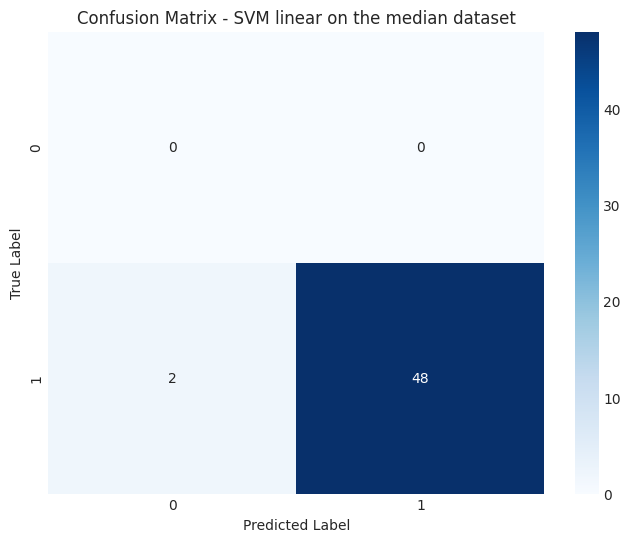

Best Parameters: {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



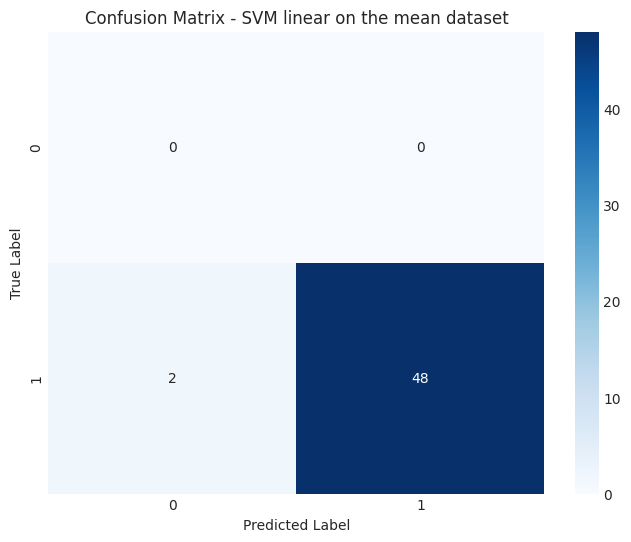

Best Parameters: {'C': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.99      0.49        50
weighted avg       1.00      0.98      0.99        50



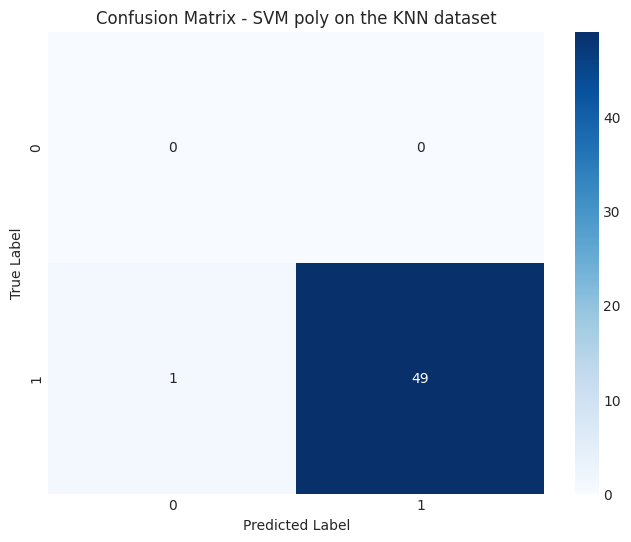

In [50]:
svm_results = test_SVM(dfs)

For SVMs, it appears my best model in terms of actually accurately predicting the class is poly where the scoring criteria is acuracy; acuraccy is the proportion of correctly classified instances.

#### Test Decision Trees

In [51]:
def plot_feat_importance(model__):
  '''
  gets a model and plots feature importance
  '''

  # Look at feature importance
  plt.figure(figsize=(10, 6))
  feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model__.feature_importances_
  })
  feature_importance = feature_importance.sort_values('Importance', ascending=False)

  sns.barplot(x='Importance', y='Feature', data=feature_importance)
  plt.title('Feature Importance in Decision Tree')
  plt.show()

In [52]:
def draw_tree(dt,best_params):
  '''
  Gets the dt model and plots it
  '''
  # Decision Tree visualization with clearer node information as we saw in the class example
  plt.figure(figsize=(25, 15))  # Larger figure size for better readability

  # Create the tree visualization with more detailed parameters
  tree_viz = tree.plot_tree(dt,
                         feature_names=X.columns,
                         class_names=['Healthy', 'Diabetic'],
                         filled=True,
                         rounded=True,
                         precision=2,  # Show 2 decimal places for values
                         proportion=True,  # Show proportions instead of counts
                         fontsize=10)  # Larger font size

  # Add text annotations to explain the node elements
  plt.annotate('Node explanation:', xy=(0.02, 0.02), xycoords='figure fraction', fontsize=12)
  plt.annotate('- Top value: Feature and threshold for splitting', xy=(0.02, -0.01), xycoords='figure fraction', fontsize=10)
  plt.annotate(f'- Middle value: {best_params["criterion"]}', xy=(0.02, -0.03), xycoords='figure fraction', fontsize=10)
  plt.annotate('- Bottom values: Sample distribution (Healthy/Diabetic)', xy=(0.02, -0.05), xycoords='figure fraction', fontsize=10)
  plt.annotate('- Blue nodes: Majority Healthy, Orange nodes: Majority Diabetic', xy=(0.02, -0.07), xycoords='figure fraction', fontsize=10)

  plt.title('Decision Tree Visualization with Enhanced Node Information', fontsize=16)
  plt.tight_layout()
  plt.show()

In [53]:
def test_dts(dfs):
  '''
  tests different parameters on decision trees on dfs of different imputation methods
  '''

  #name of dfs to add context to confusion matricies
  dfnames = ['median', 'mean', 'KNN']
  i = 0
  for df in dfs:
    X_train, X_test, y_train, y_test = spliter(df, scale=False)

    #Decsision trees can generally handle imbalanced data so I did not weigh it or balance the data and it would not perform so now I am applying SMOTE

    #Apply SMOTE due to high class imbalance

    #apply SMOTE because SVMs do not perform on highly imbalanced data
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train[y_train == 0])-1)) #set k_neighbors to be at most the size of the minority class - 1
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    #apply stratfied kfold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #define parameters
    #max_depth=3, min_samples_split=10

    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [i for i in range(1,5)],
                  'min_samples_split': [7, 9, 10, 15],
                  'splitter': ['best', 'random']
                    }

    dt = DecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(dt, param_grid, cv=stratified_kfold, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)

    #get the best parameters and model
    best_params_dt = grid_search.best_params_
    best_model_dt = grid_search.best_estimator_

    #test the best model
    y_pred = best_model_dt.predict(X_test)

    #output classification results and the best parameters
    print("Best Parameters:", best_params_dt)
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

    labels = [0, 1] #fix cm

    #plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm_dt = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Decision Tree {best_params_dt["criterion"]} on the {dfnames[i]} dataset')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    plt.show()

    #Visualize trees
    draw_tree(best_model_dt, best_params_dt)
    #plot feature importance
    plot_feat_importance(best_model_dt)

    dfnames[i] = [dfnames[i], y_pred, best_params_dt] #store ypred for further comparison
    i+=1 #iterate index

  return dfnames

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



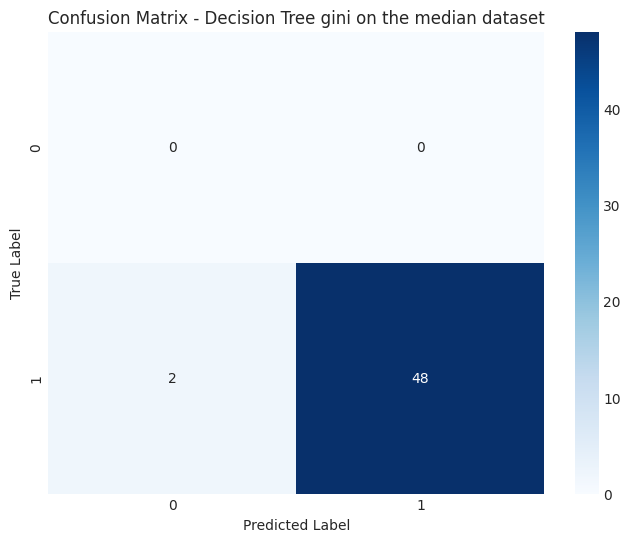

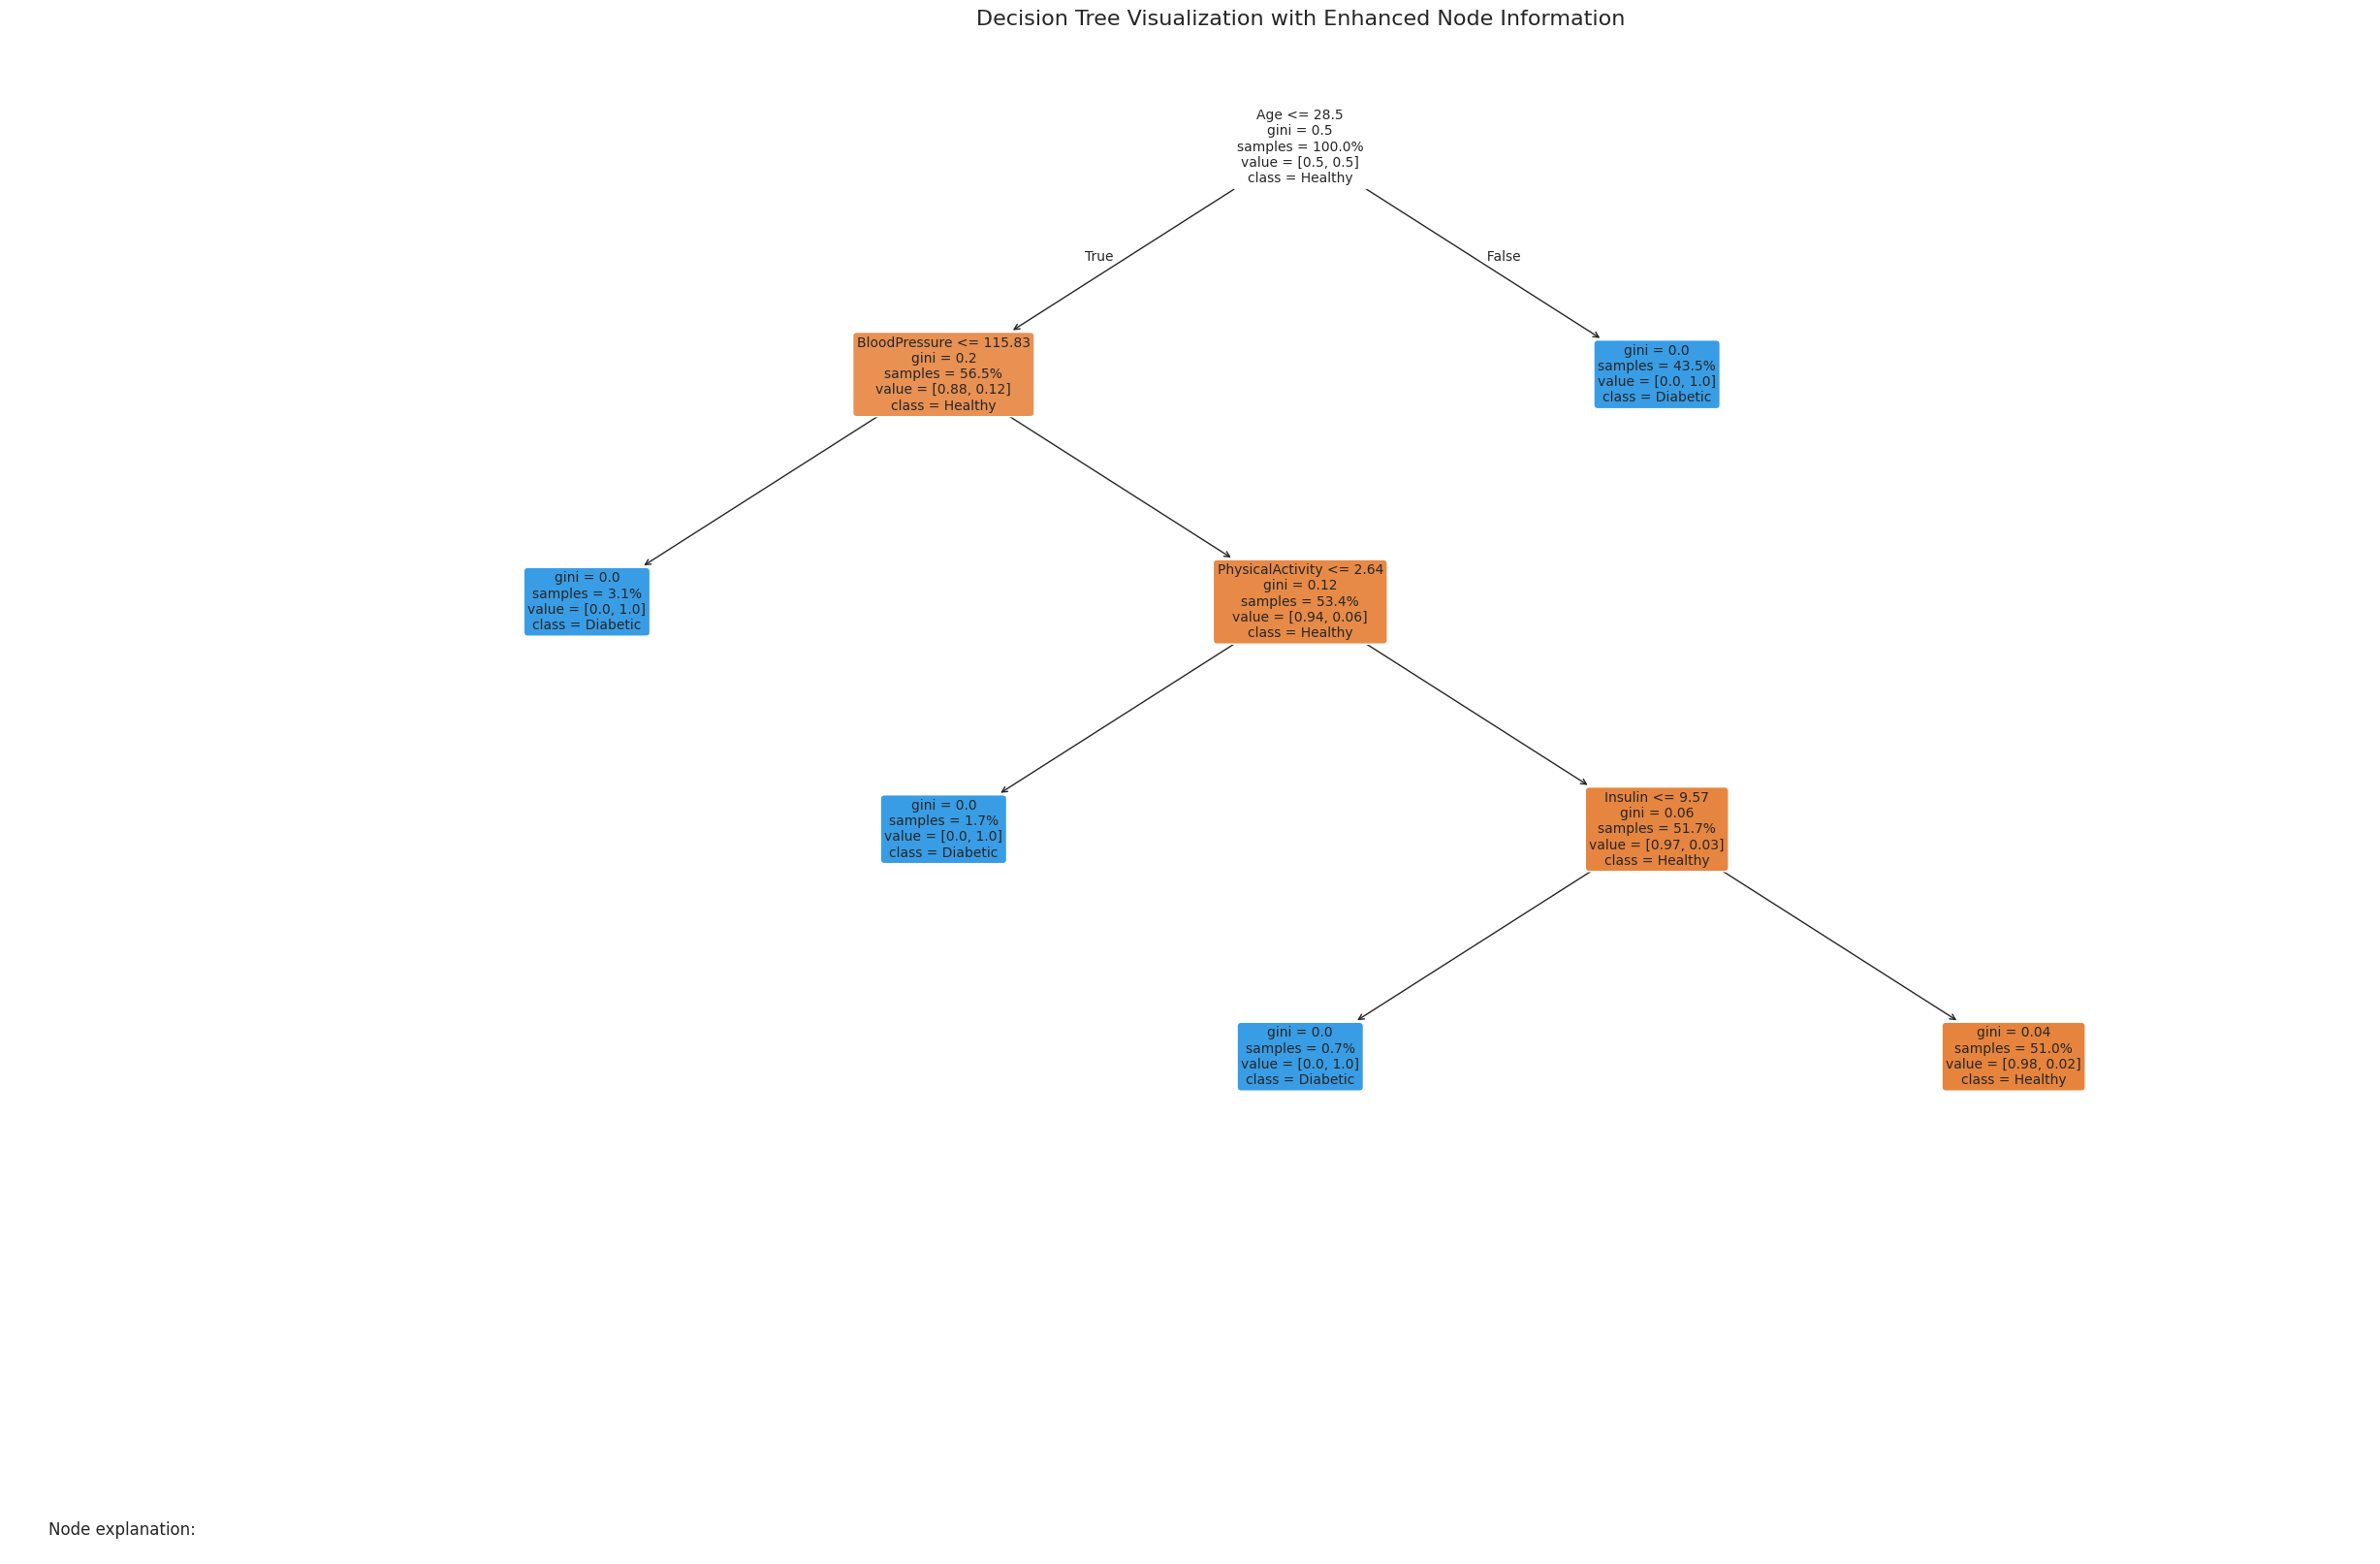

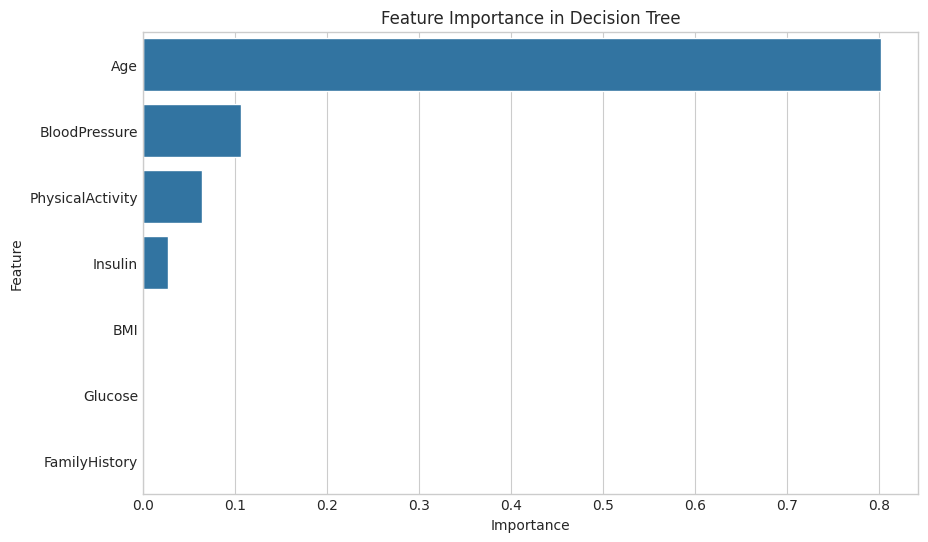

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



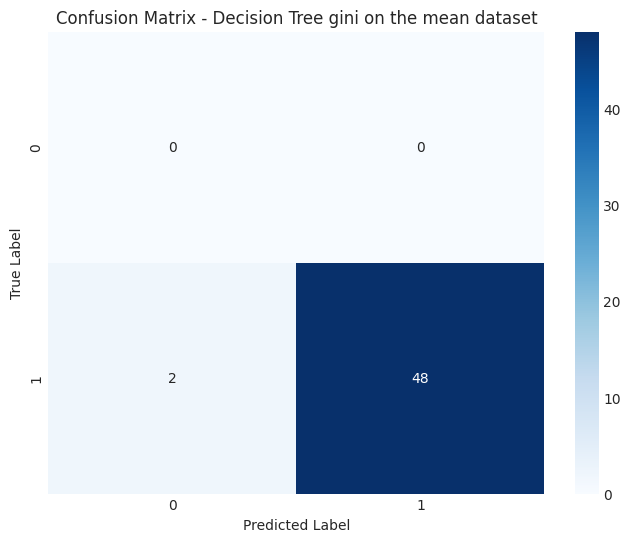

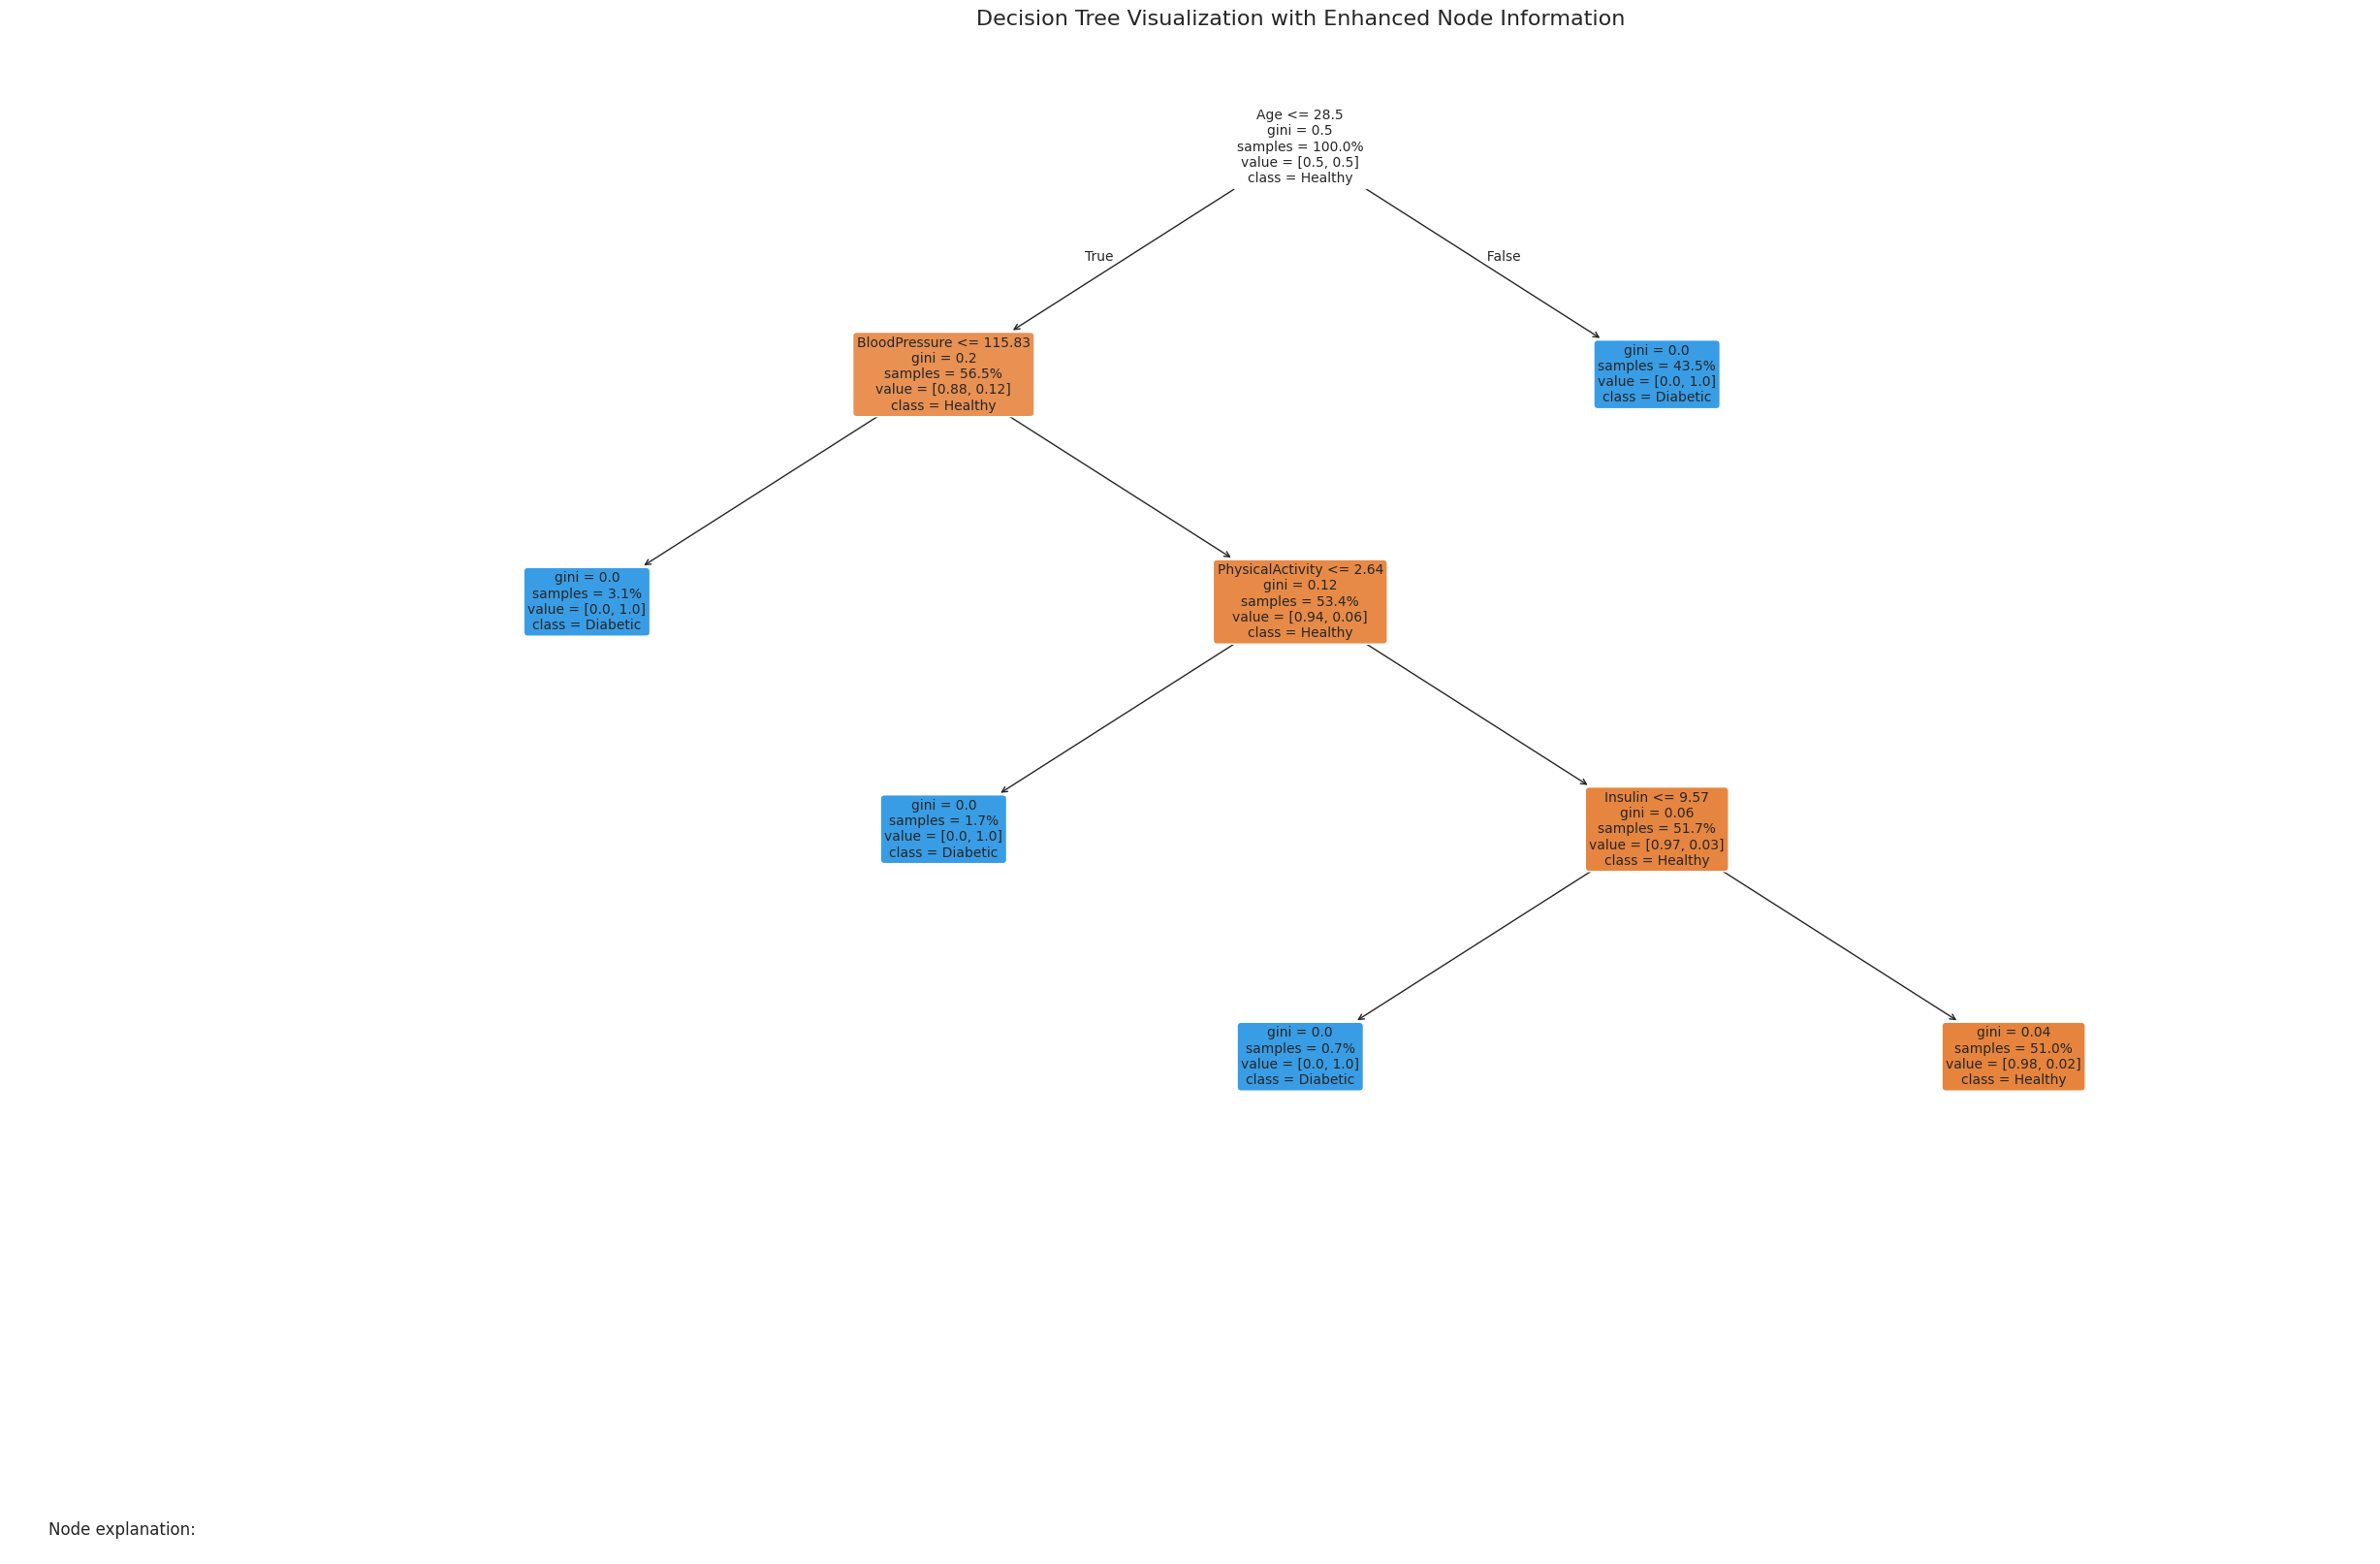

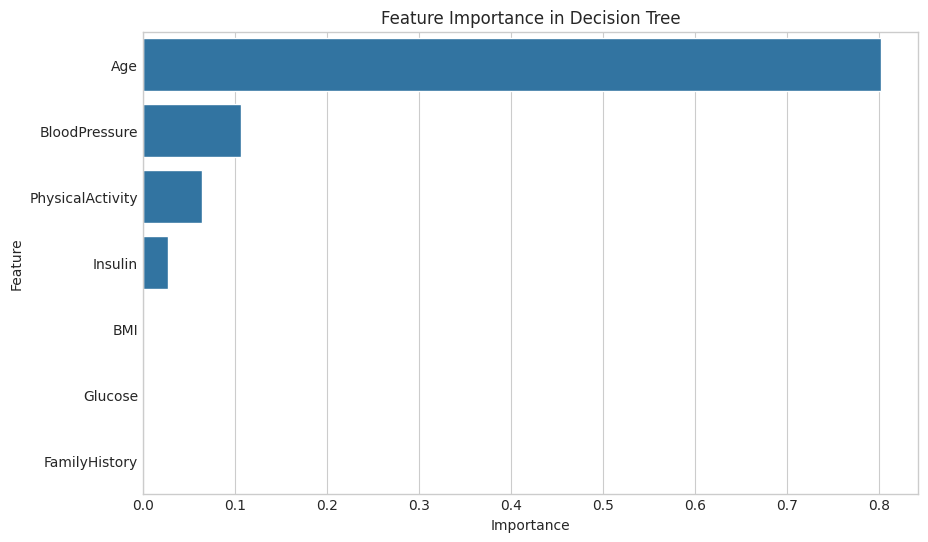

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       1.00      0.94      0.97        50

    accuracy                           0.94        50
   macro avg       0.50      0.97      0.48        50
weighted avg       1.00      0.94      0.97        50



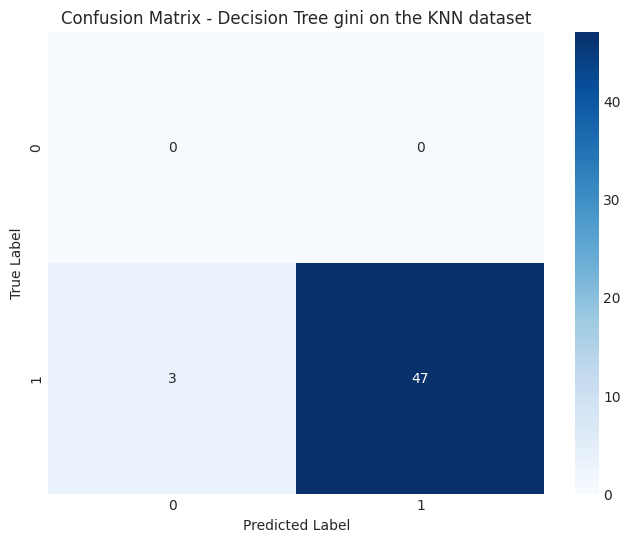

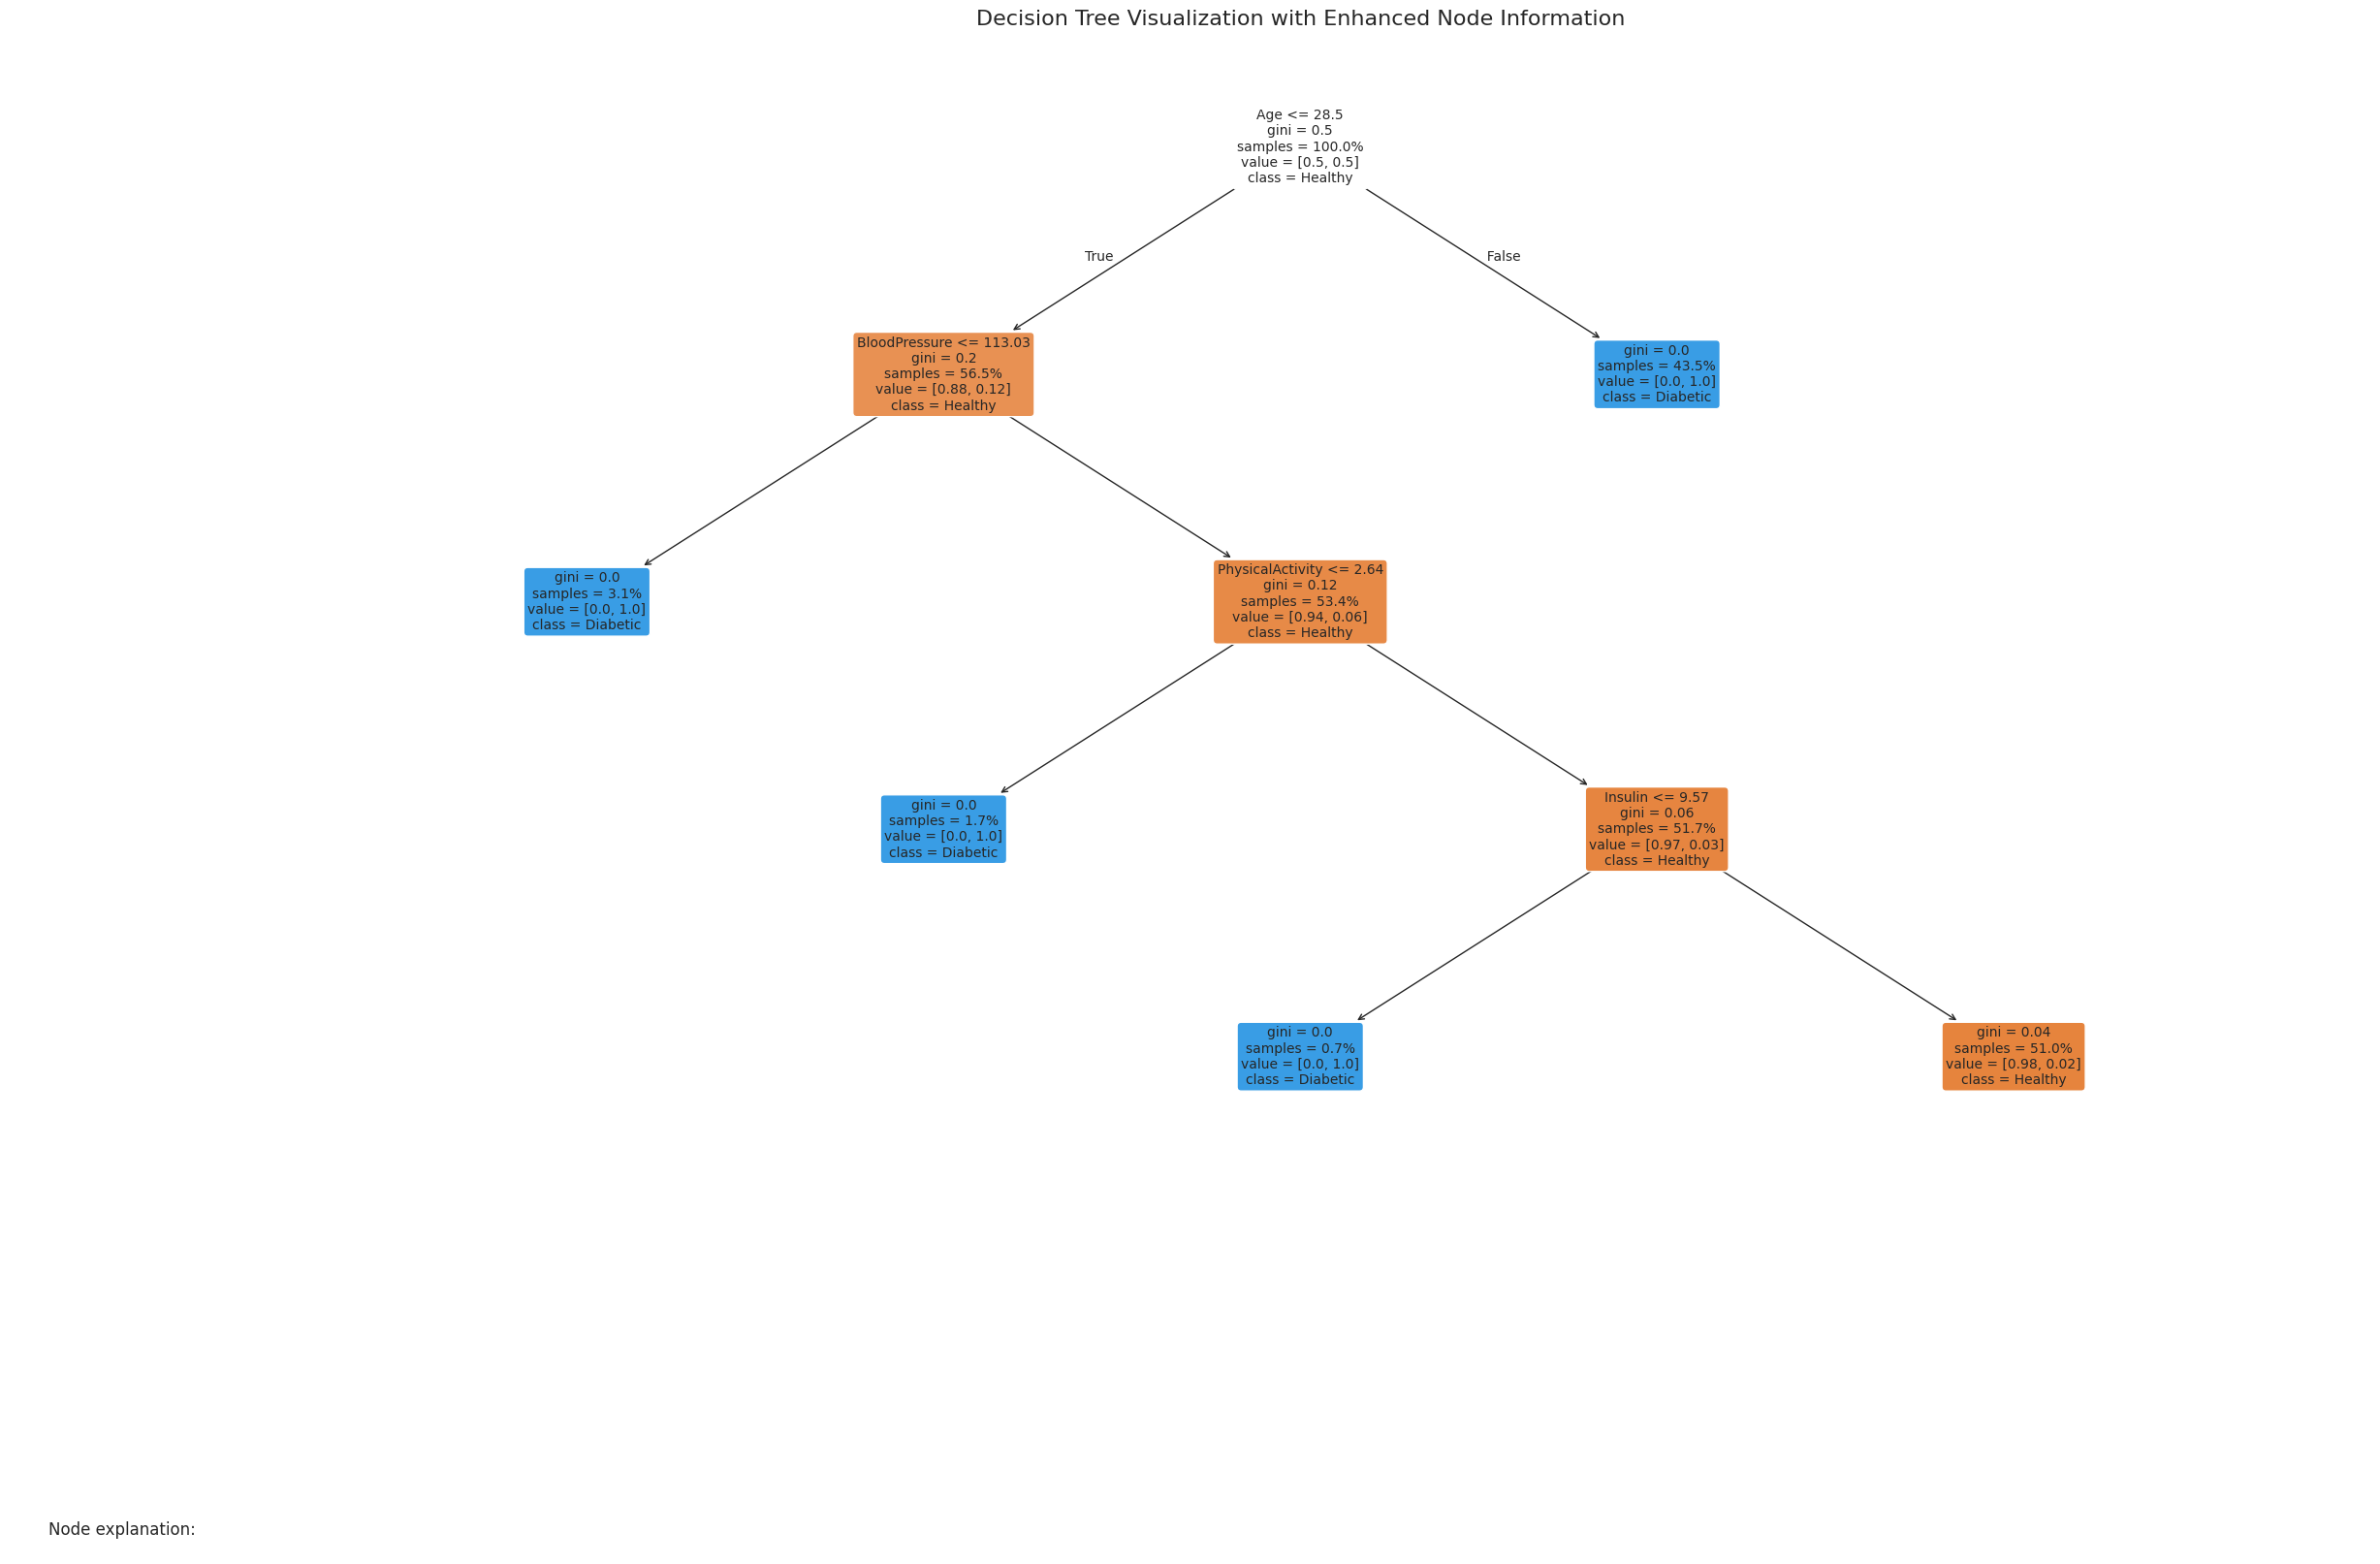

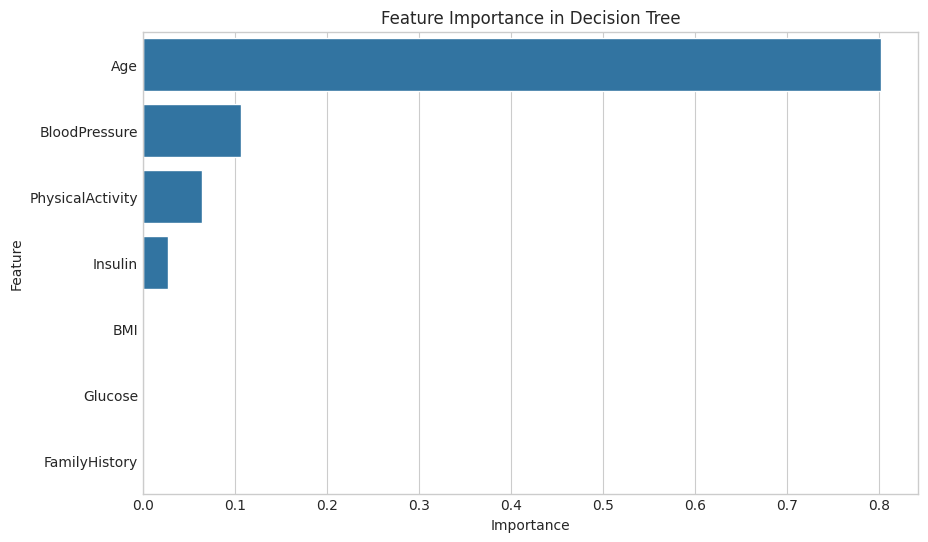

In [54]:
dt_results = test_dts(dfs)

Interestingly I got essentially the same tree with almost the same parameters for all three imputation methods and all three models chose GINI as the criterion

>all three DTs chose age, BP, phys activity, and insulin as the most important features in that order, with little variance

max_depth controls how deep a tree can grow, min_samples_split controls how many samples can be in a node before it needs to split. Entropy and GINI are just parameters to decide the best way to split a way

> SVMs at a high dimensiality are inherintly hard to understand because the are at d, dimensions. After a certian point, I would argue two dimensions, if the kenel is not linear, it becomes very difficult if not impossible to interpert an SVM due to it being too complex visually. On the other hand, the decision trees are easy to interpret because at each node, the split critera and the split criteria are explicit at each node, allowing for any layman to interpret the decison tree.


#### Compare model accuracy

In [55]:
#isolate names and y preds from the lists derived from testing models

print(svm_results)

svm_names = ['SVM: imputation:median kernel:linear', 'SVM: imputation:mean kernel:linear', 'SVM: imputation:KNN kernel:poly']
svm_ypreds = [svm_results[0][1], svm_results[1][1], svm_results[2][1]]

print(dt_results)
dt_names = ['Decision Tree: imputation:median criterion:gini', 'Decision Tree: imputation:mean criterion:gini', 'Decision Tree: imputation:KNN criterion:gini']
dt_ypreds = [dt_results[0][1], dt_results[1][1], dt_results[2][1]]


[['median', array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1]), {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}], ['mean', array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1]), {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}], ['KNN', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), {'C': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}]]
[['median', array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1]), {'criterion': 'gini', 'max_

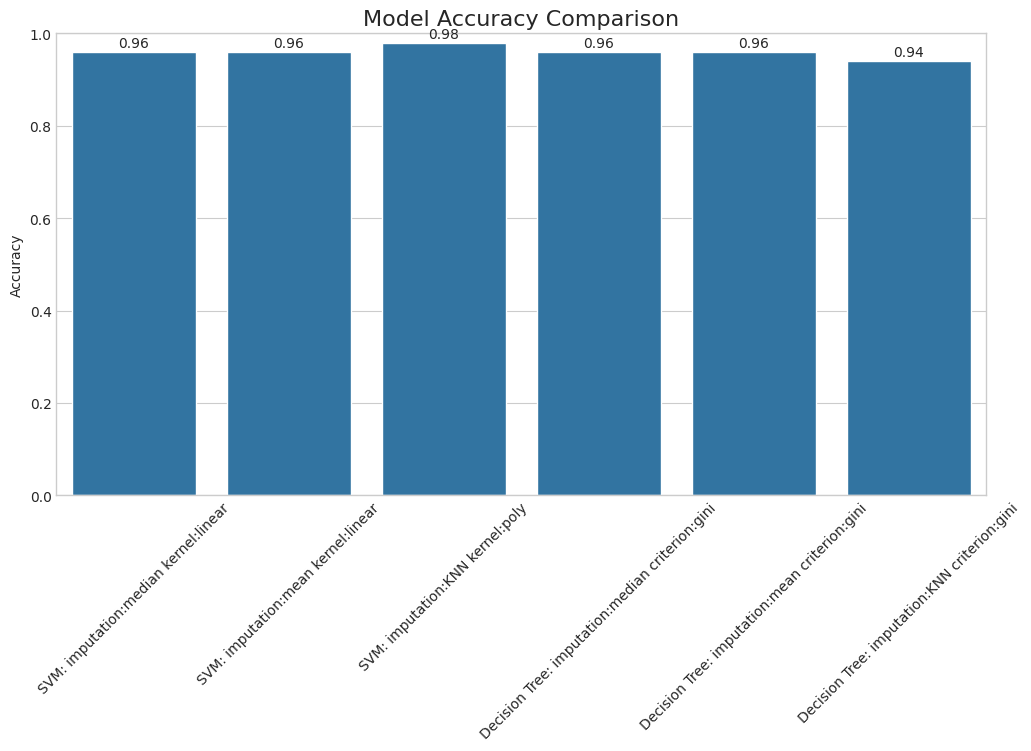


Accuracy Comparison:
SVM: imputation:median kernel:linear: 96.00%
SVM: imputation:mean kernel:linear: 96.00%
SVM: imputation:KNN kernel:poly: 98.00%
Decision Tree: imputation:median criterion:gini: 96.00%
Decision Tree: imputation:mean criterion:gini: 96.00%
Decision Tree: imputation:KNN criterion:gini: 94.00%


In [56]:
models = svm_names + dt_names
y_preds = svm_ypreds + dt_ypreds
accuracies = [accuracy_score(y_test, y_pred) for y_pred in y_preds]

plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center')
plt.show()

print("\nAccuracy Comparison:")
for model, acc in zip(models, accuracies):
    print(f"{model}: {acc * 100:.2f}%")

>It appears the most accurate model is the SVM that was trained on the dataset that used KNN to impute missing data with a polynomial kernel

> I applied cross validation to prevent against overfitting on the unseen data for both models so it can generalize against the actual real world data.

>I believe in terms of understanding, ie this model is supposed to predict diabetes, the decision tree may still make sense, even with a redution in accuracy because it is easy to understand how and why a patient may have been classified as healthy or diabetic, which I consider more important than a slight drop in accuracy as interpretation is likely an important factor in model selection for the medical field.

#### Feature selection/reduction

As age, BP, phys activity, and insulin were found to be the most important in the descion trees, I am going to try only using those for svms and dts.

Best Parameters: {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



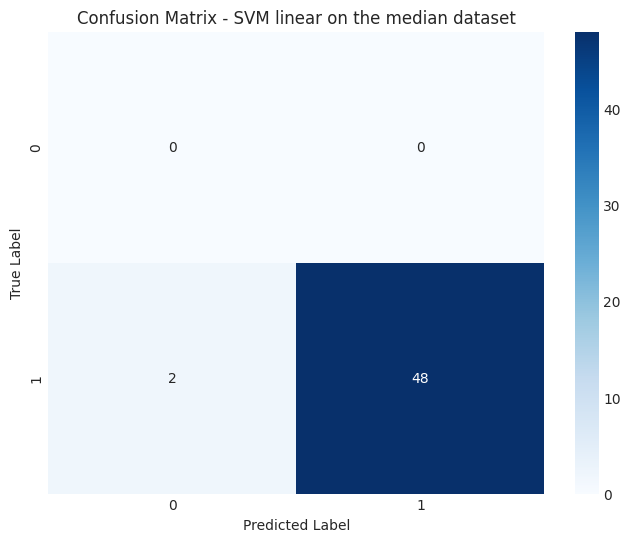

Best Parameters: {'C': 0.7, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



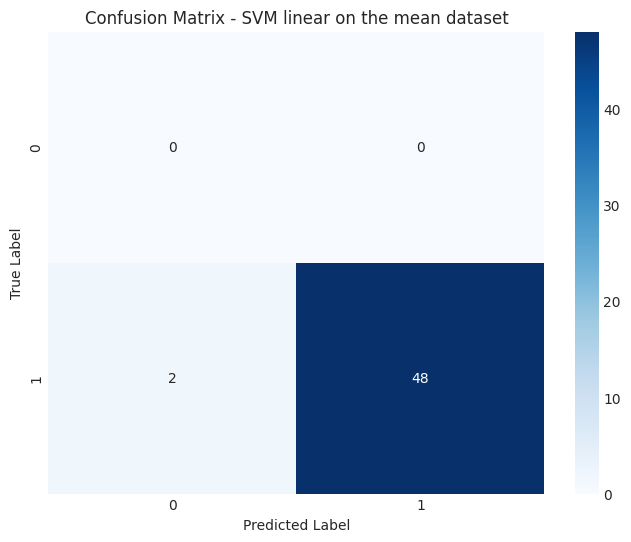

Best Parameters: {'C': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        50
   macro avg       0.50      0.99      0.49        50
weighted avg       1.00      0.98      0.99        50



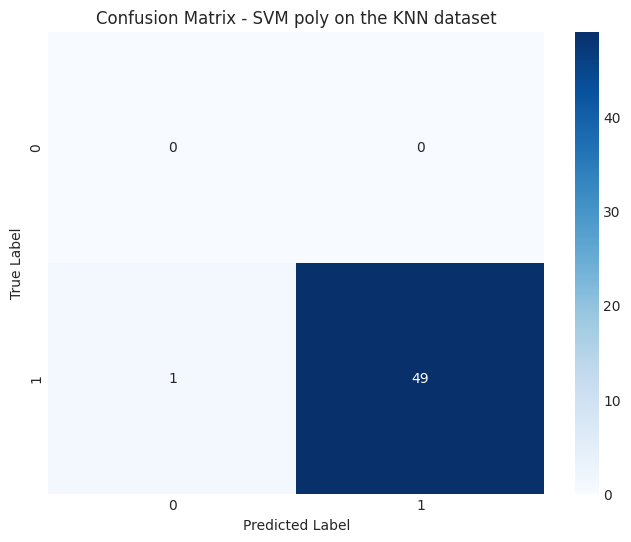

In [57]:
for df in dfs:
  df = df[['Age', 'BloodPressure', 'PhysicalActivity', 'Insulin', 'Diagnosis']]

fs_SVM_results = test_SVM(dfs)

It is interesting that there is a slight drop in accuracy in the SVMs after dropping glucose, family history, and BMI

>This may mean one or more of these features are crucial in the accurate prediciton of diagnosis

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



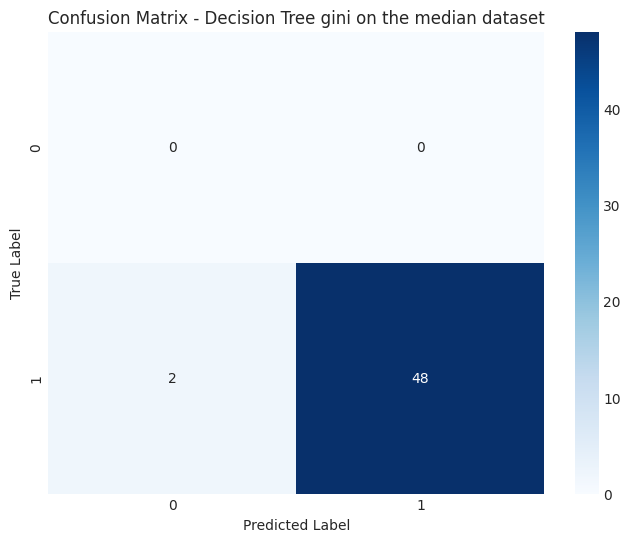

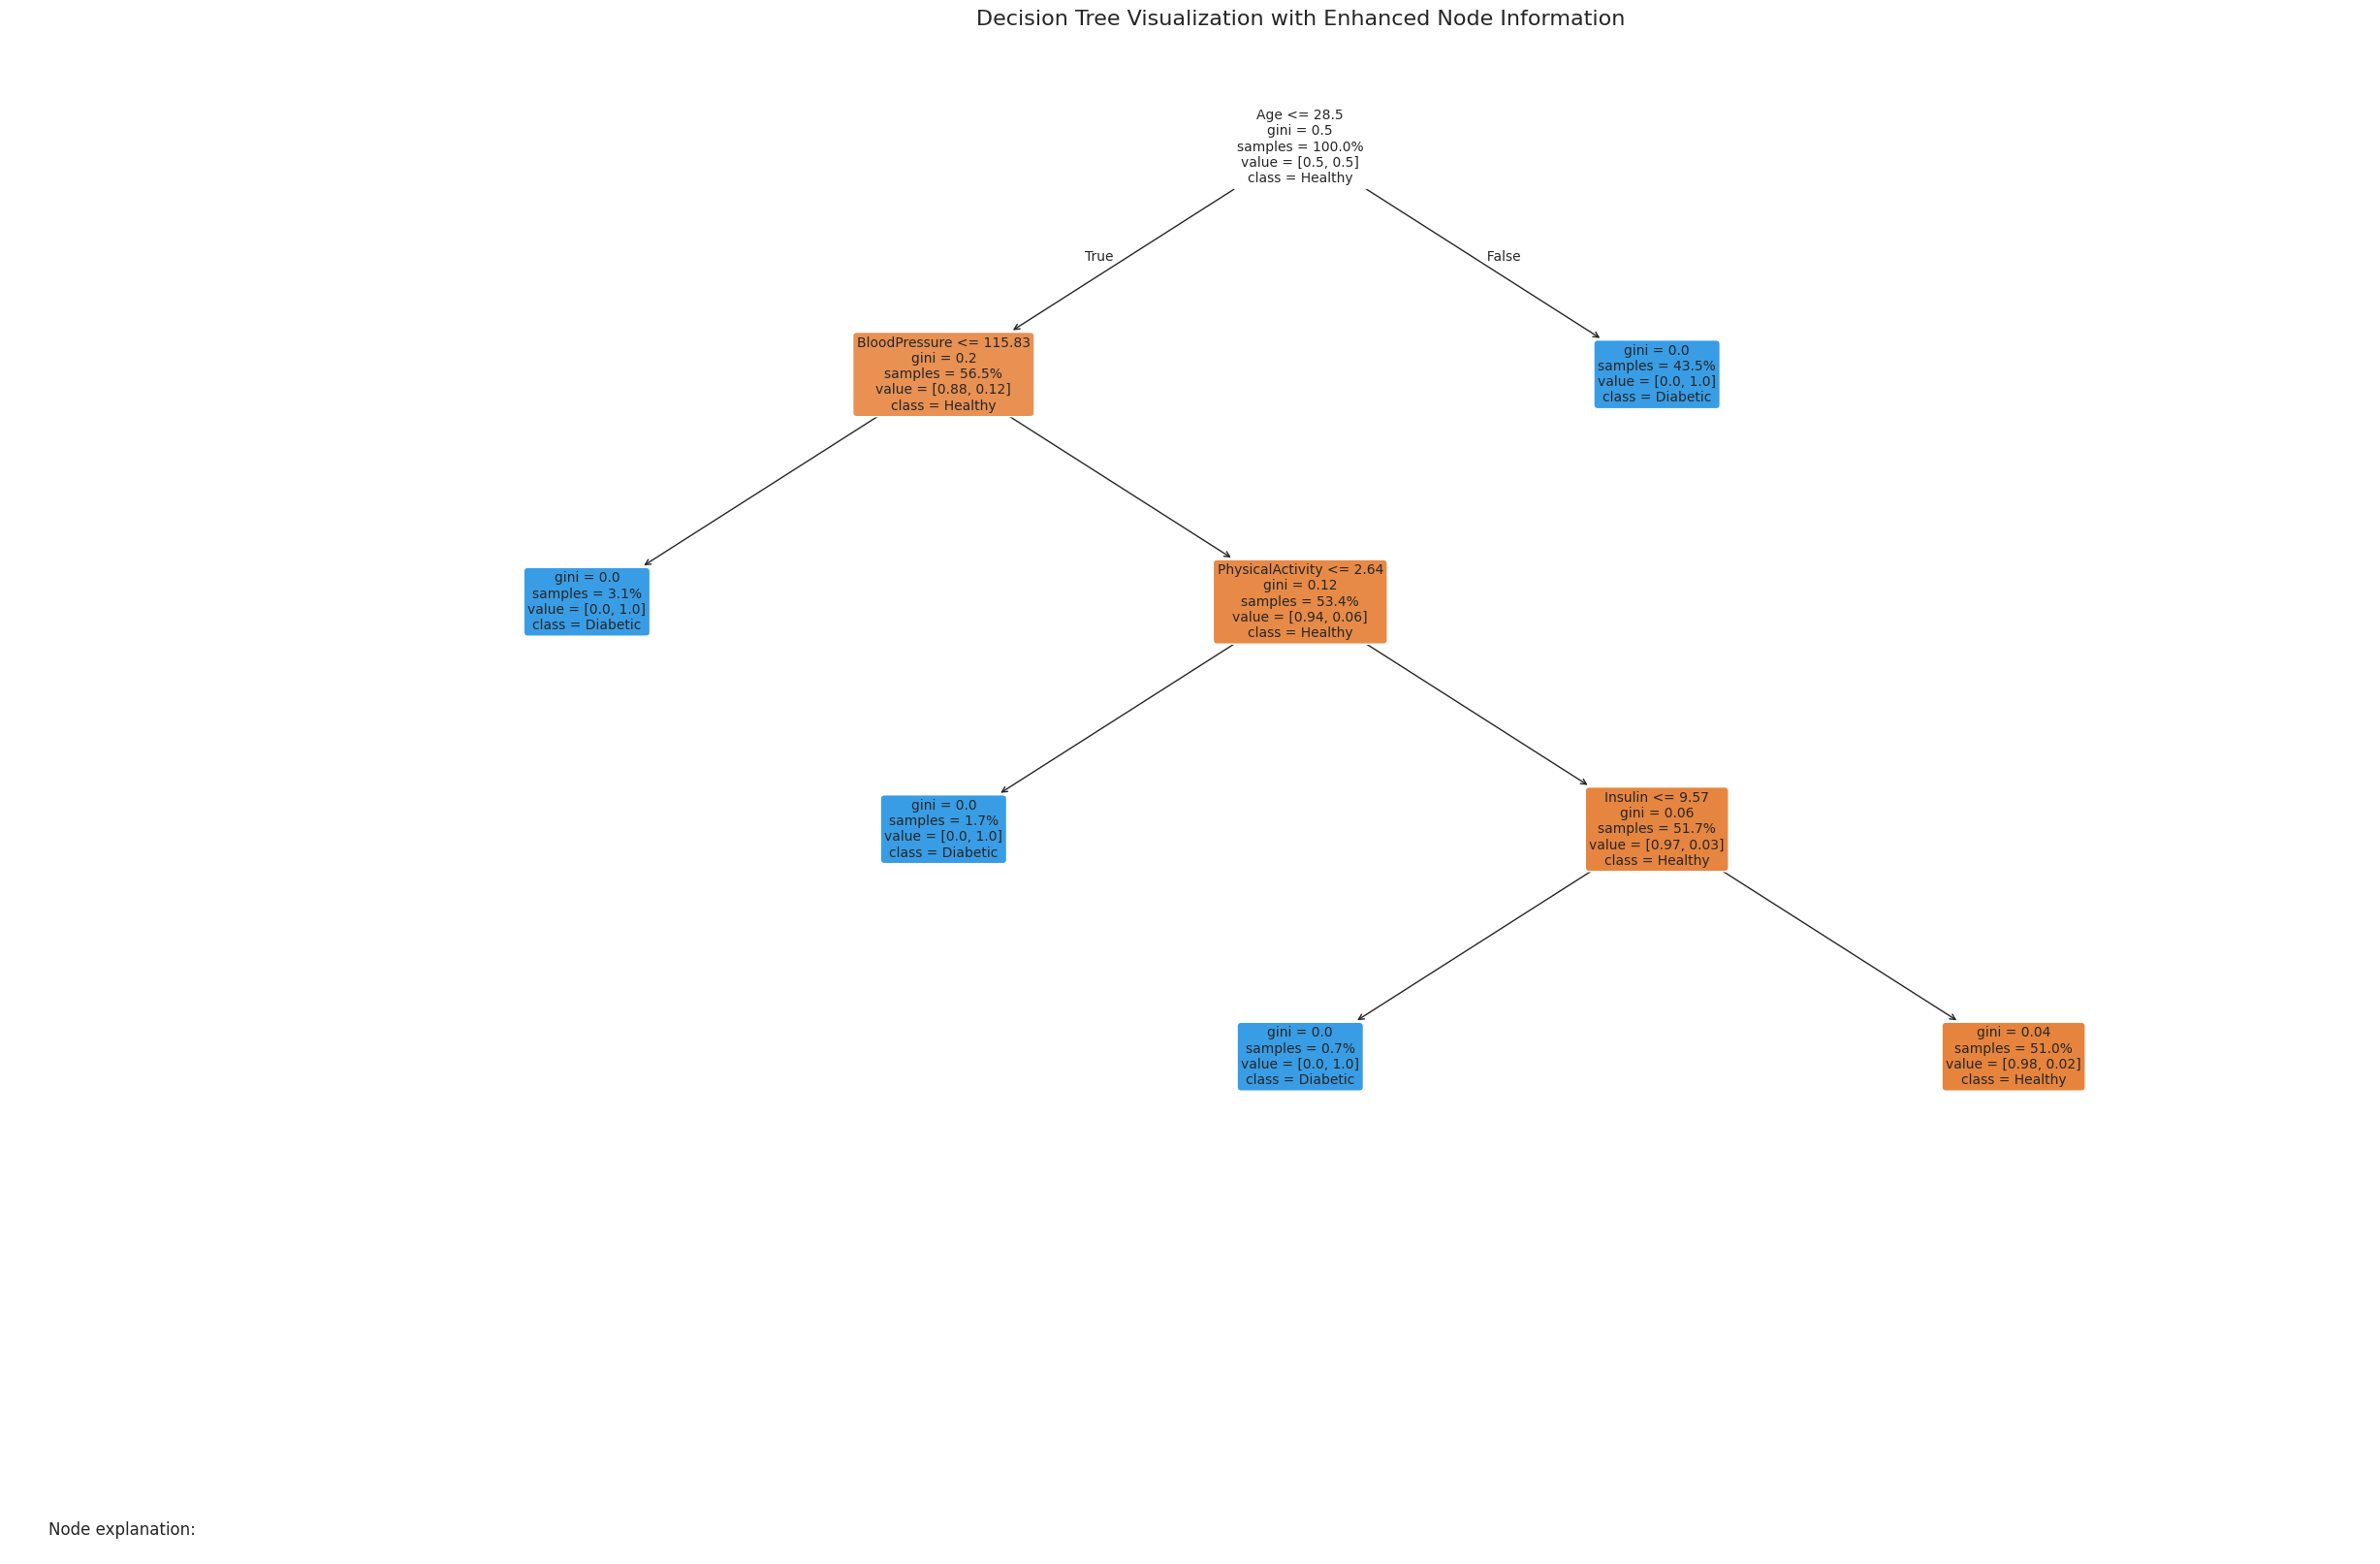

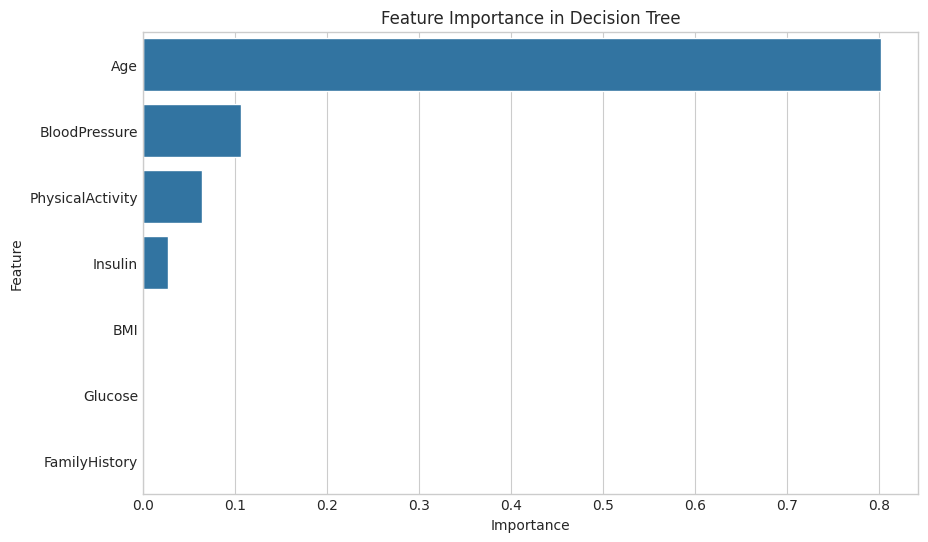

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.96      0.98        50

    accuracy                           0.96        50
   macro avg       0.50      0.98      0.49        50
weighted avg       1.00      0.96      0.98        50



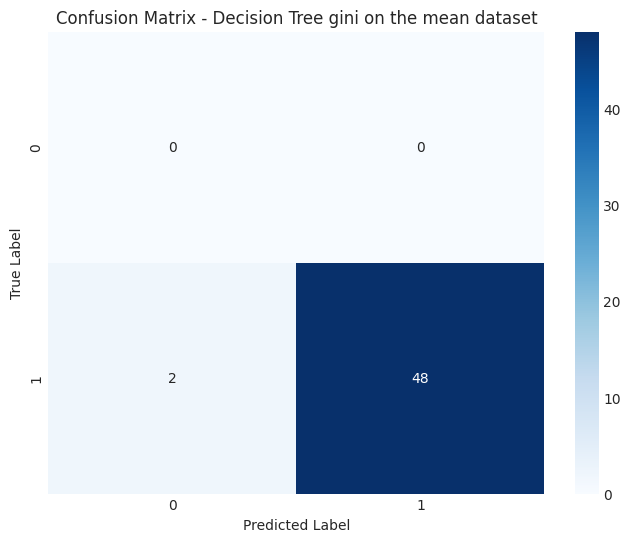

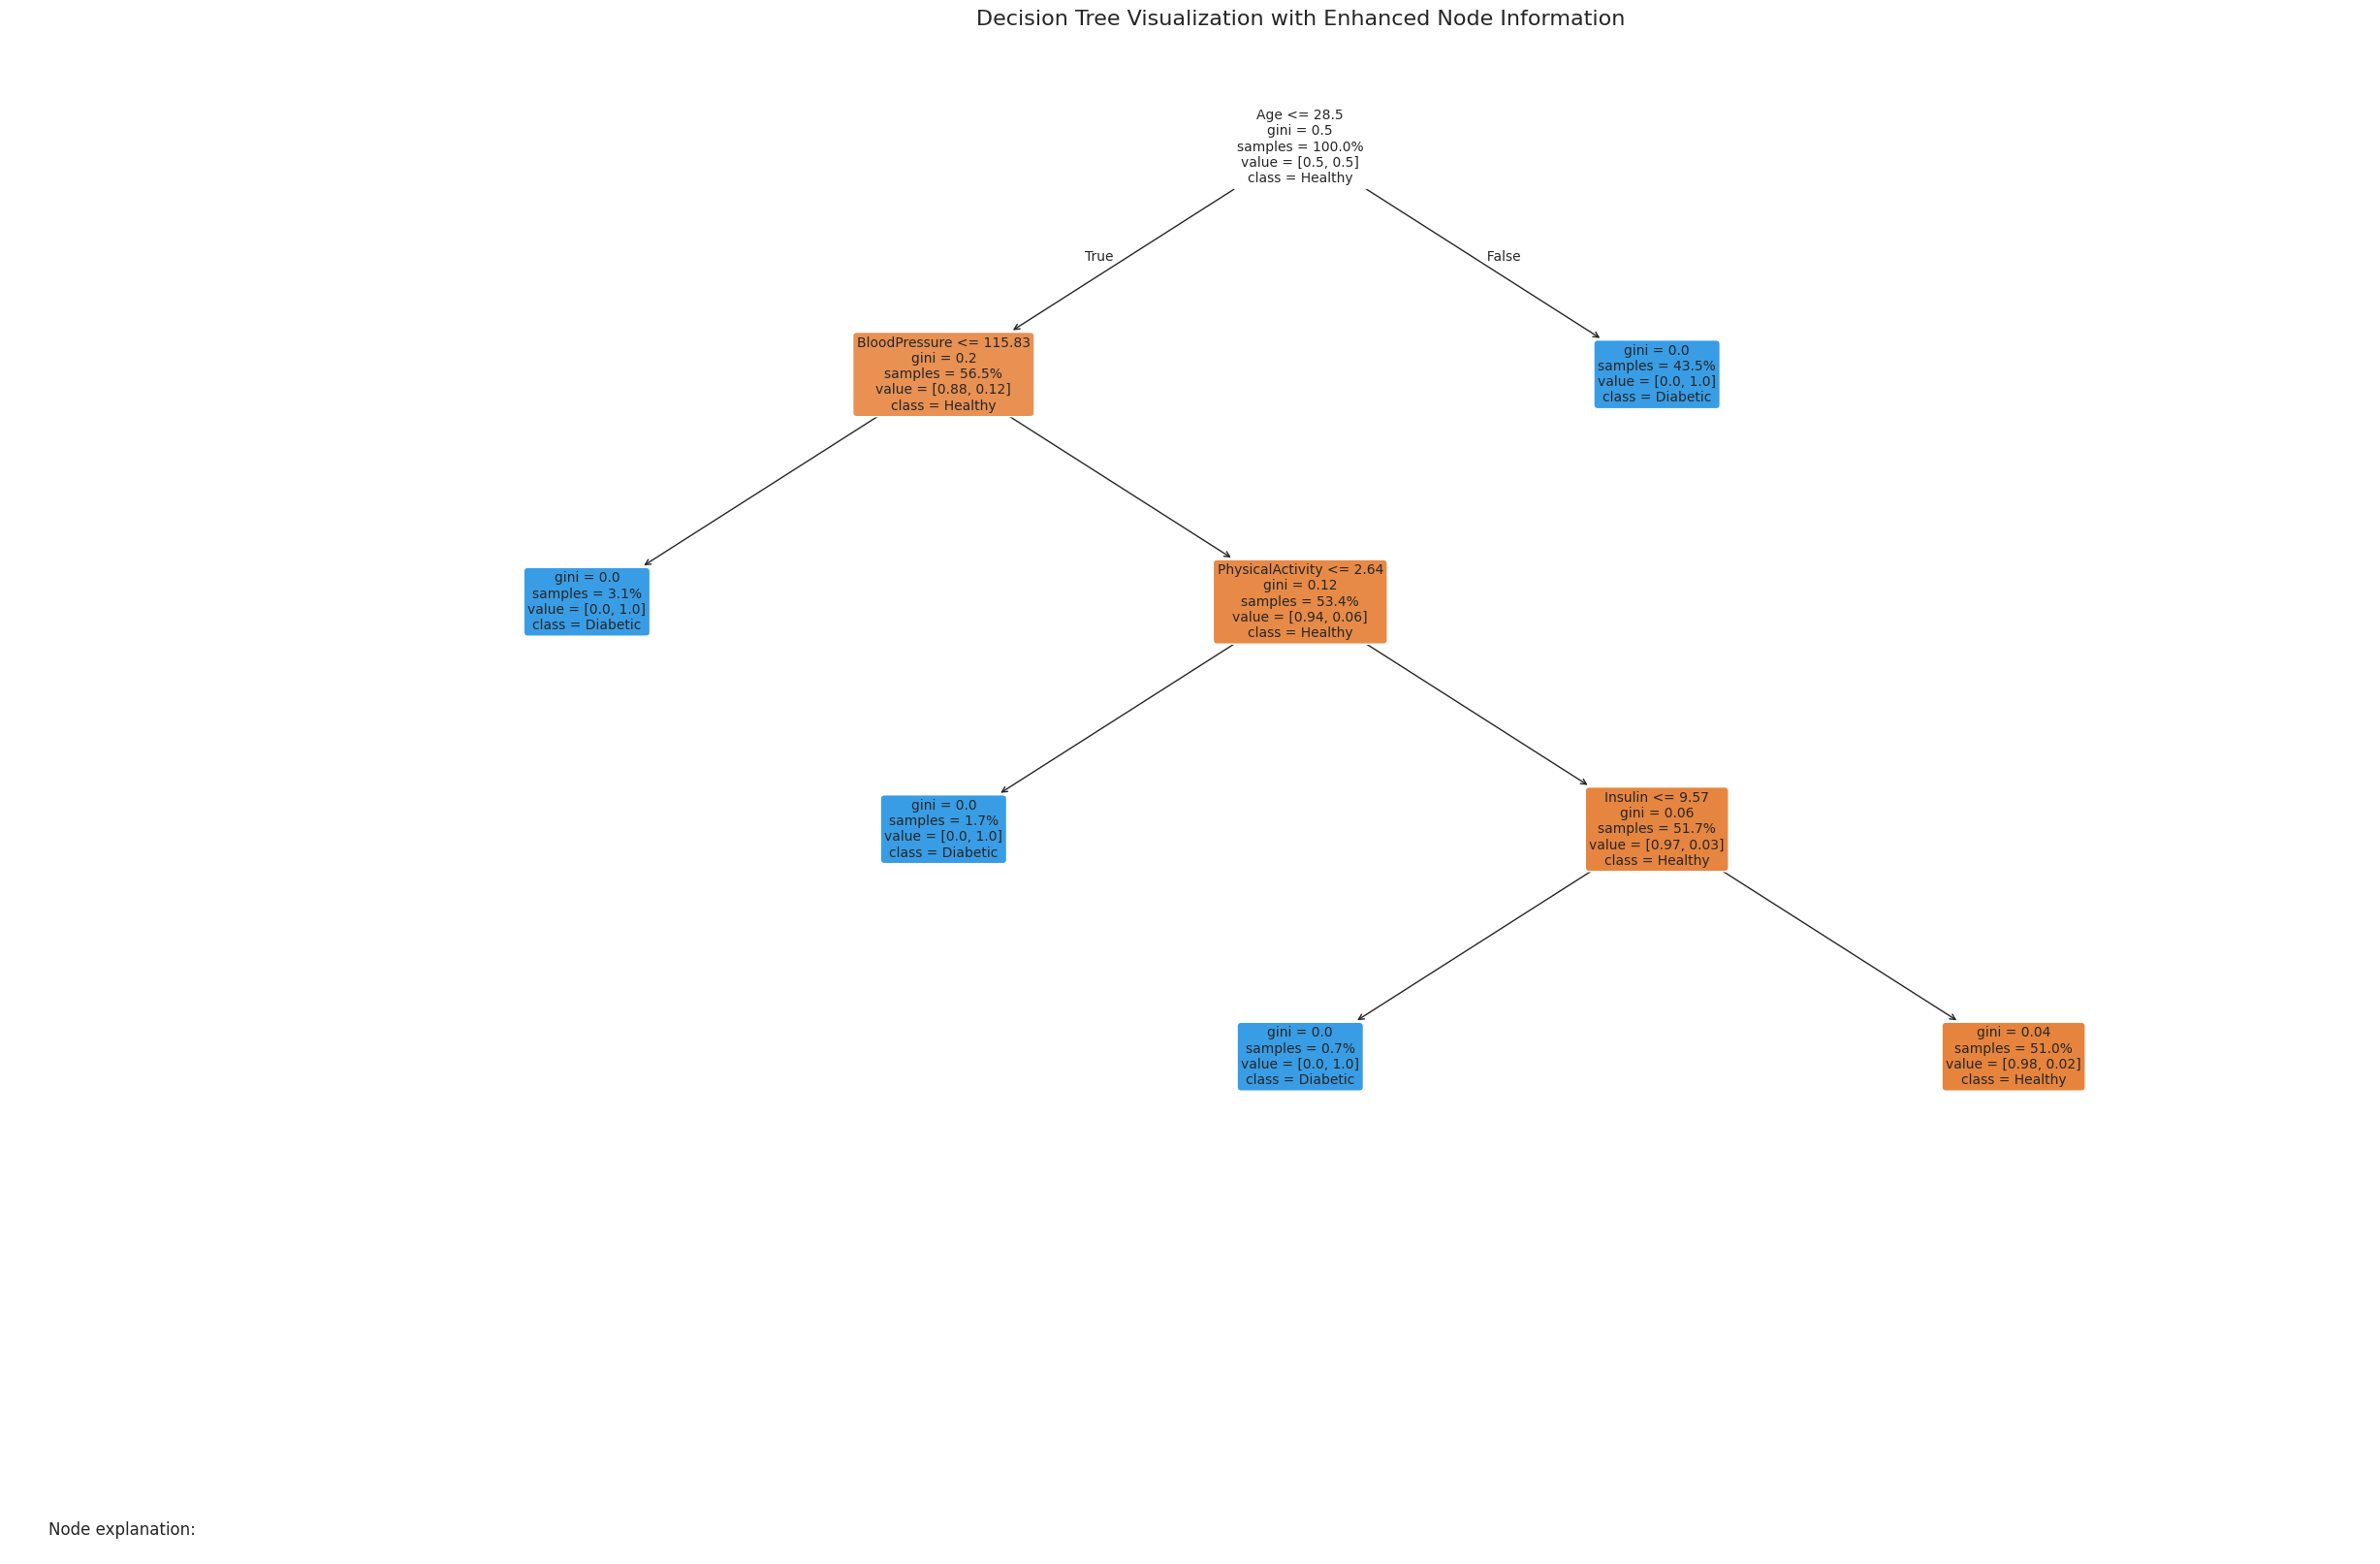

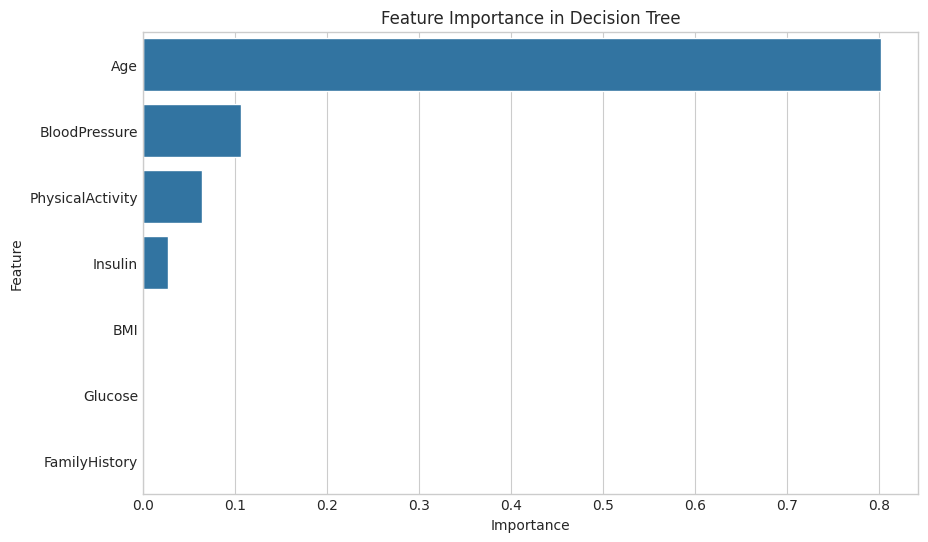

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       1.00      0.94      0.97        50

    accuracy                           0.94        50
   macro avg       0.50      0.97      0.48        50
weighted avg       1.00      0.94      0.97        50



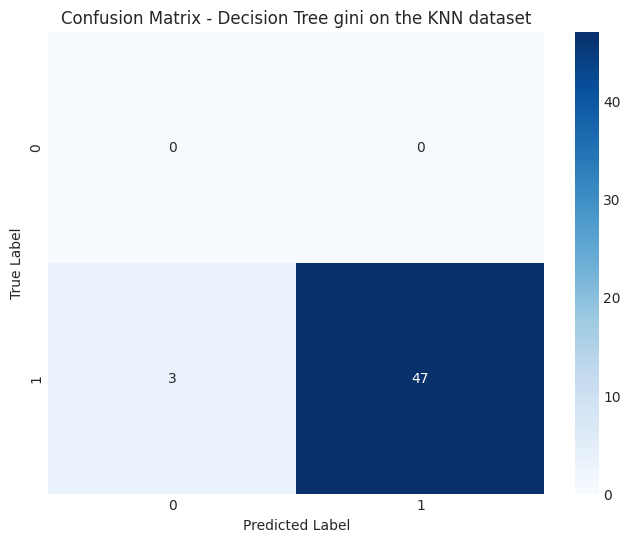

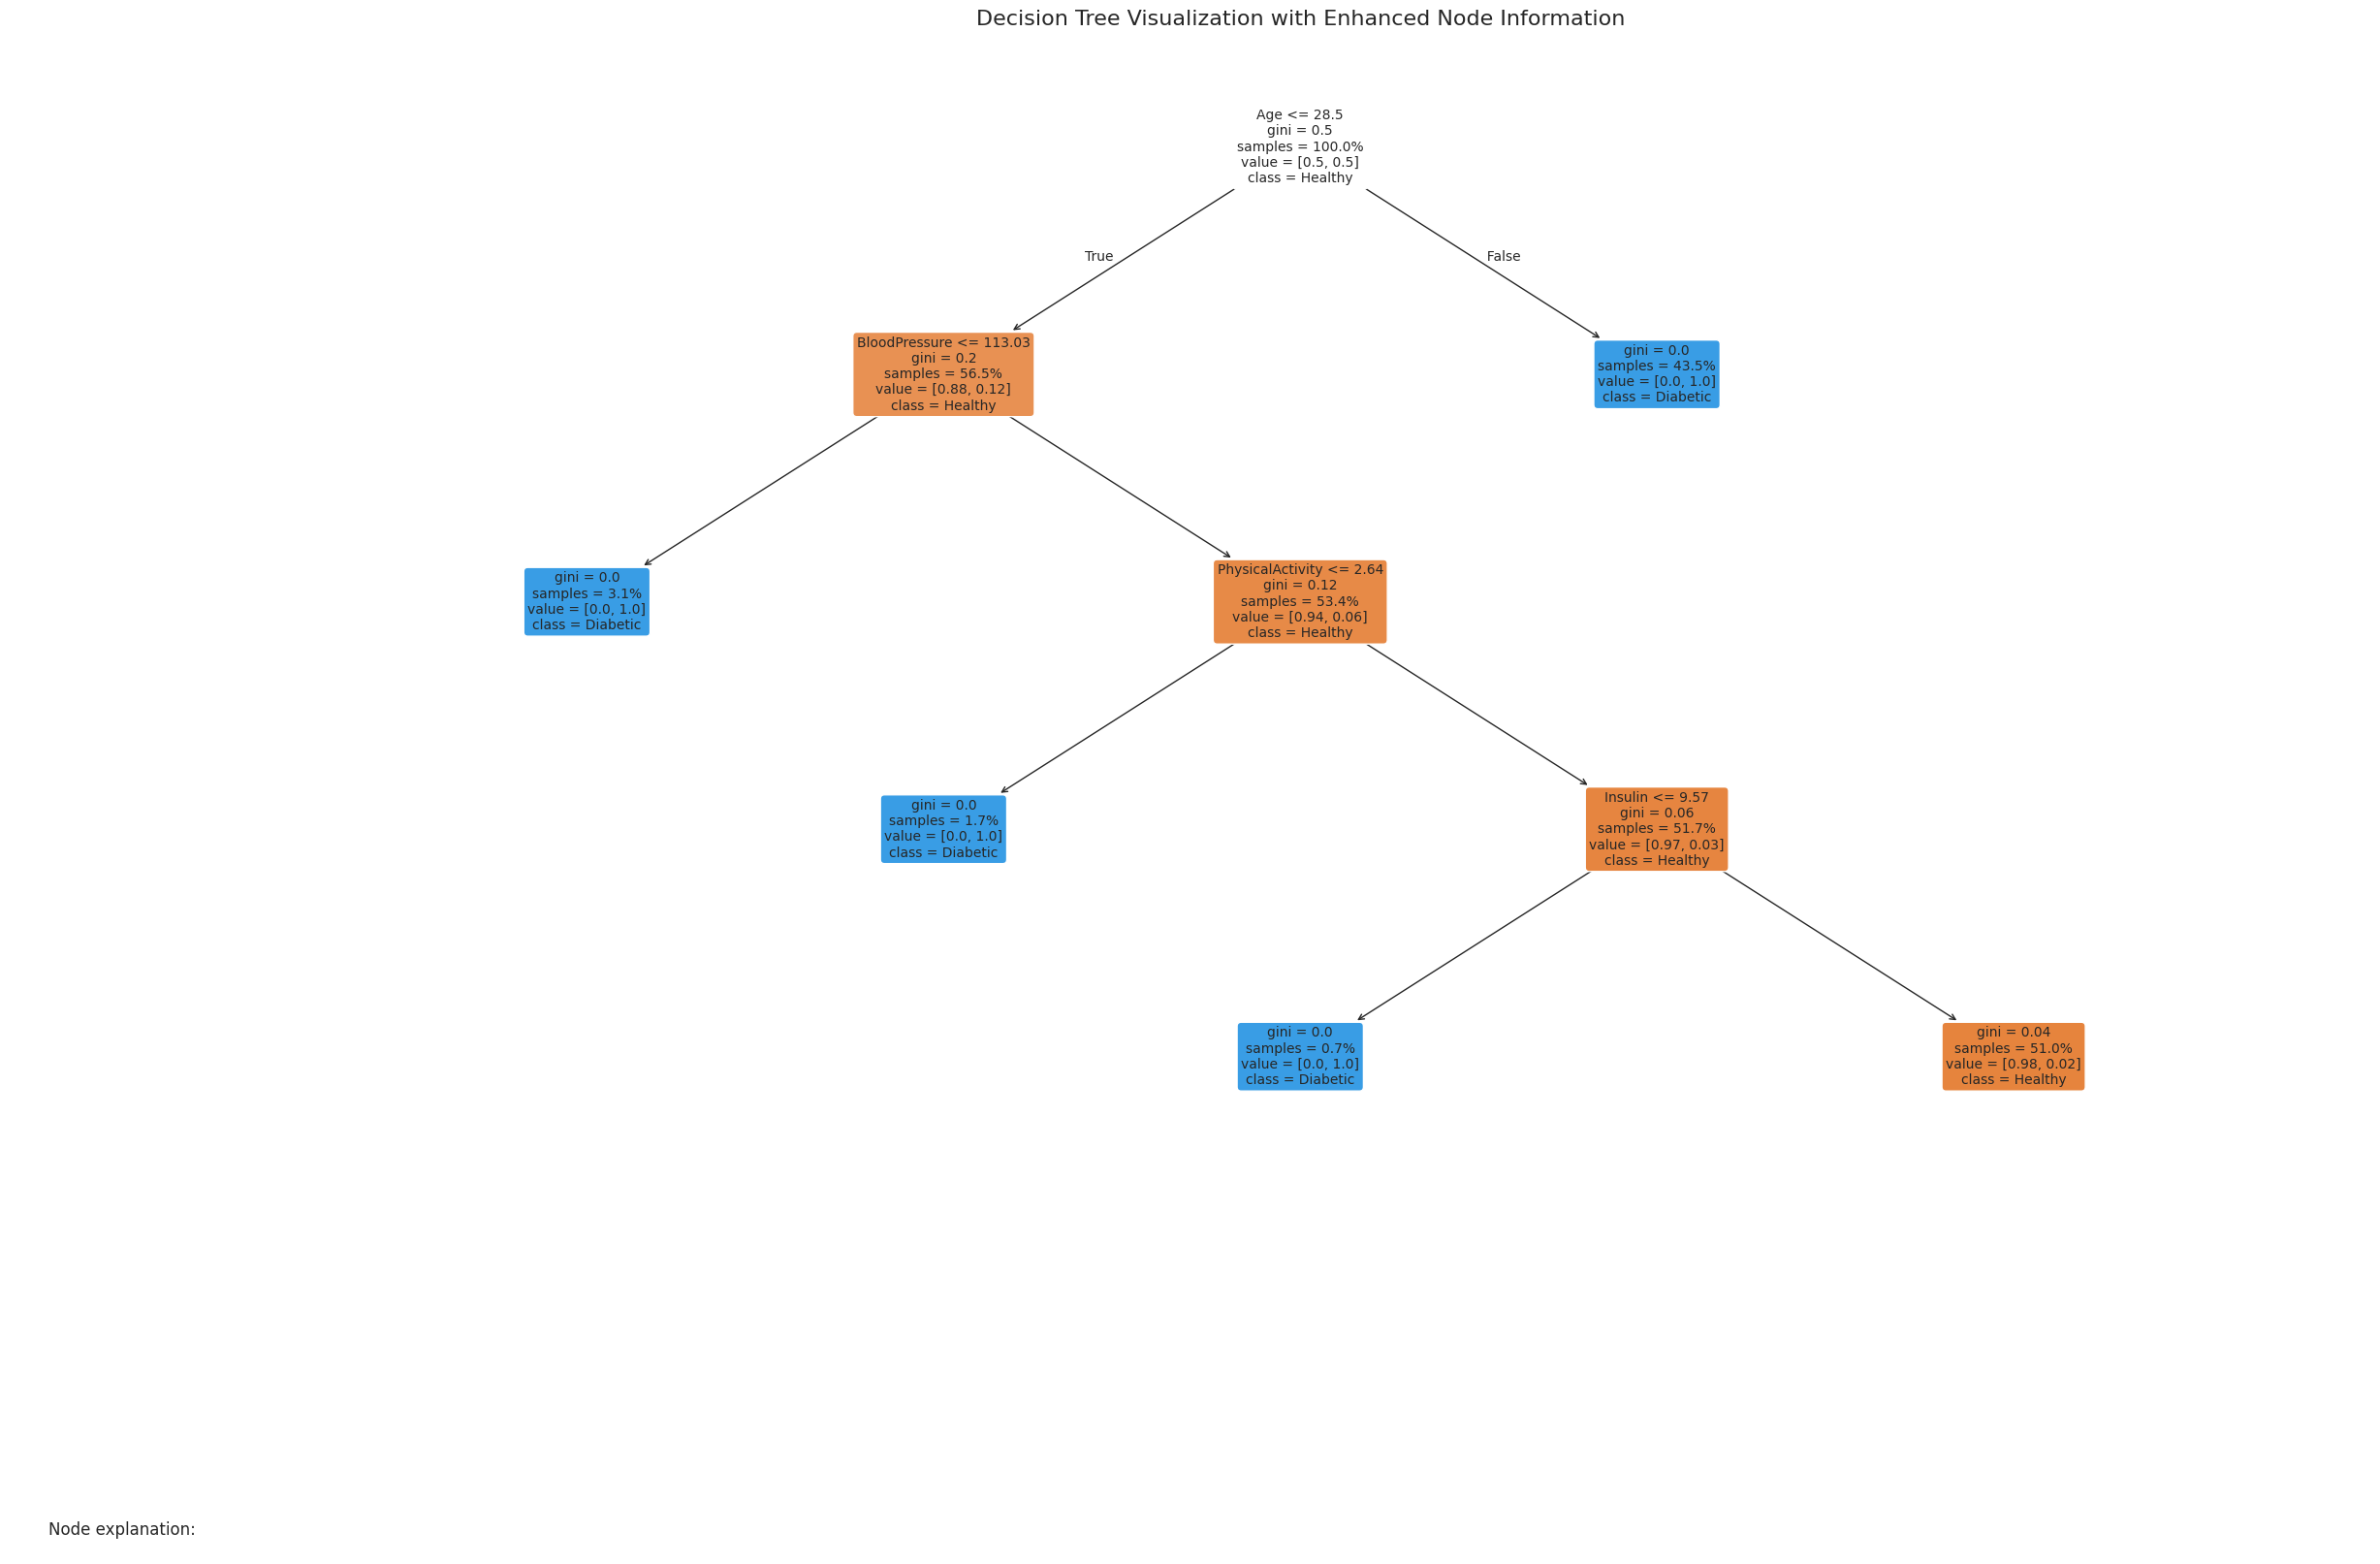

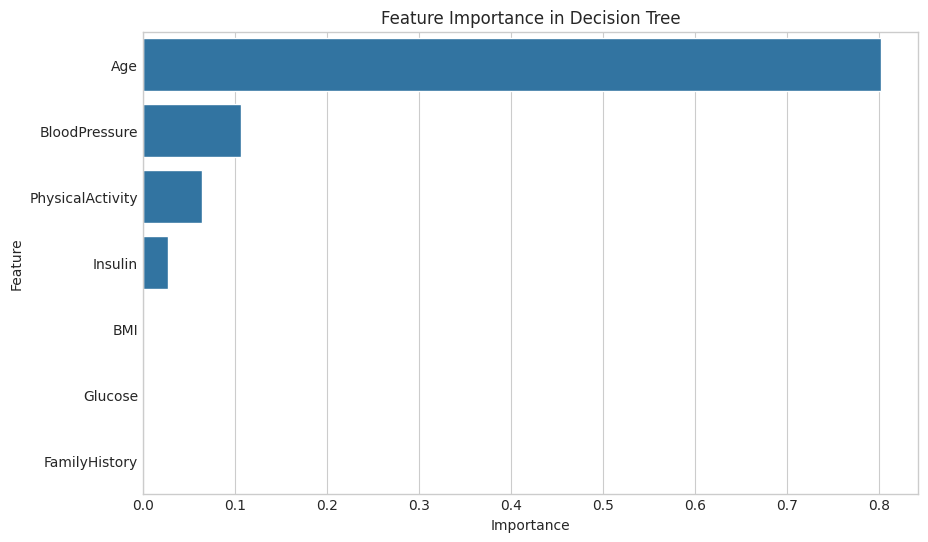

In [58]:
fs_DT_results = test_dts(dfs)

Unsuprisingly dropping said features doesn't noiceably change the decision trees

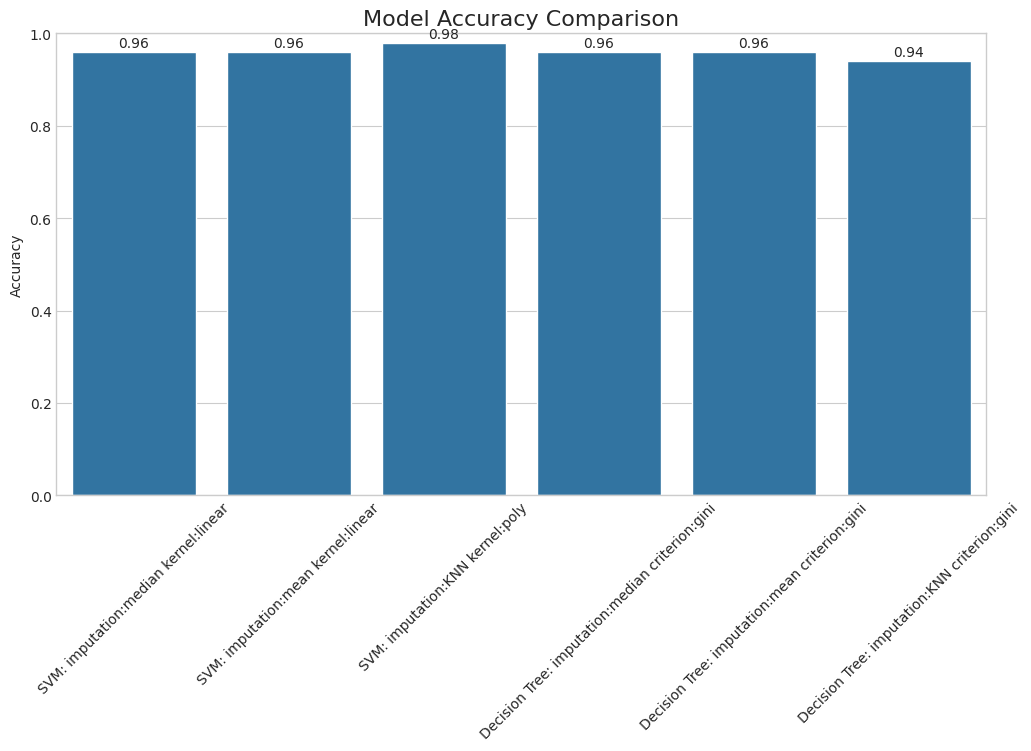


Accuracy Comparison:
SVM: imputation:median kernel:linear: 96.00%
SVM: imputation:mean kernel:linear: 96.00%
SVM: imputation:KNN kernel:poly: 98.00%
Decision Tree: imputation:median criterion:gini: 96.00%
Decision Tree: imputation:mean criterion:gini: 96.00%
Decision Tree: imputation:KNN criterion:gini: 94.00%


In [59]:
svm_names = ['SVM: imputation:median kernel:linear', 'SVM: imputation:mean kernel:linear', 'SVM: imputation:KNN kernel:poly']
svm_ypreds = [fs_SVM_results[0][1], fs_SVM_results[1][1], fs_SVM_results[2][1]]

dt_names = ['Decision Tree: imputation:median criterion:gini', 'Decision Tree: imputation:mean criterion:gini', 'Decision Tree: imputation:KNN criterion:gini']
dt_ypreds = [fs_DT_results[0][1], fs_DT_results[1][1], fs_DT_results[2][1]]

models = svm_names + dt_names
y_preds = svm_ypreds + dt_ypreds
accuracies = [accuracy_score(y_test, y_pred) for y_pred in y_preds]

plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center')
plt.show()

print("\nAccuracy Comparison:")
for model, acc in zip(models, accuracies):
    print(f"{model}: {acc * 100:.2f}%")

The decision tree classifier used uses the CART algorithim that is based on the CART algorithim. The CART algorithim is a good fit for this data, because our goal is to classify and it is easily interpretable. Although, the current sk learn implementation cannot handle catagortical valiues which may pose a issue with our dataset.

> The decision tree is easy to interpret which is crucial for medical fields. My recomendation based on the models performances, is to use the polynomial SVM to screen potential patients looking for a diagnosis, and then apply a decision tree to interpret why they had risk factors or were diagnosed as diabetic. The dual approach is needed here as SVM based modeling was found to be more performant which is important in medical screening. However, finding the risk factors and explaining them is just as important. Because SVMs, in this case are more accurate, I prepose a approach using SVMs to screen for diagnosses and Decision Trees to explain the diagnosis.

## Assignment Complete!

Congratulations on completing this machine learning assignment on medical diagnosis classification using SVM and Decision Trees!

## Grading Rubric (100 Points Total)

Your assignment will be graded according to the following rubric:

### Task 1: Analyze the dataset and identify relationships between features and the target (15 points)
- **Excellent (13-15 points)**: Comprehensive analysis with multiple visualization techniques, clear identification of key relationships, and insightful interpretation of findings.
- **Good (10-12 points)**: Solid analysis with appropriate visualizations and identification of main relationships.
- **Satisfactory (7-9 points)**: Basic analysis with some visualizations and identification of obvious relationships.
- **Needs Improvement (0-6 points)**: Minimal or incorrect analysis with few or no visualizations.

### Task 2: Experiment with different methods to handle missing values (15 points)
- **Excellent (13-15 points)**: Implementation of multiple imputation methods (mean, median, KNN), comparison of their effects on model performance, and thoughtful discussion of trade-offs.
- **Good (10-12 points)**: Implementation of at least two imputation methods with comparison of results.
- **Satisfactory (7-9 points)**: Implementation of one alternative imputation method with basic analysis.
- **Needs Improvement (0-6 points)**: Minimal or incorrect implementation of imputation methods.

### Task 3: Experiment with different SVM kernels (15 points)
- **Excellent (13-15 points)**: Implementation of multiple kernels (linear, RBF, poly) with different parameters, thorough analysis of performance differences, and clear explanation of when each kernel is appropriate.
- **Good (10-12 points)**: Implementation of at least two kernels with some parameter tuning and performance comparison.
- **Satisfactory (7-9 points)**: Implementation of one additional kernel with basic analysis.
- **Needs Improvement (0-6 points)**: Minimal or incorrect implementation of SVM kernels.

### Task 4: Experiment with different Decision Tree parameters (15 points)
- **Excellent (13-15 points)**: Systematic exploration of multiple parameters (max_depth, min_samples_split, min_samples_leaf, criterion), visualization of resulting trees, and analysis of how each parameter affects model complexity and performance.
- **Good (10-12 points)**: Exploration of at least two parameters with visualization and performance comparison.
- **Satisfactory (7-9 points)**: Adjustment of one parameter with basic analysis.
- **Needs Improvement (0-6 points)**: Minimal or incorrect parameter adjustment.

### Task 5: Implement cross-validation (10 points)
- **Excellent (9-10 points)**: Implementation of k-fold cross-validation with appropriate k value, analysis of variance in performance metrics, and discussion of how cross-validation improves model evaluation.
- **Good (7-8 points)**: Implementation of cross-validation with basic analysis of results.
- **Satisfactory (5-6 points)**: Basic implementation of cross-validation without detailed analysis.
- **Needs Improvement (0-4 points)**: Incorrect or missing implementation of cross-validation.

### Task 6: Try feature selection (10 points)
- **Excellent (9-10 points)**: Implementation of multiple feature selection methods, comparison of model performance with different feature subsets, and discussion of the importance of feature selection.
- **Good (7-8 points)**: Implementation of one feature selection method with analysis of results.
- **Satisfactory (5-6 points)**: Basic feature selection without detailed analysis.
- **Needs Improvement (0-4 points)**: Incorrect or missing implementation of feature selection.

### Task 7: Compare the interpretability of SVM vs Decision Trees (10 points)
- **Excellent (9-10 points)**: In-depth comparison of interpretability with specific examples, discussion of trade-offs between performance and interpretability, and consideration of real-world implications.
- **Good (7-8 points)**: Clear comparison with examples and basic discussion of trade-offs.
- **Satisfactory (5-6 points)**: Basic comparison without detailed examples or discussion.
- **Needs Improvement (0-4 points)**: Minimal or incorrect comparison.

## Submission Requirements
- All code must be well-commented and properly organized in the notebook
- All visualizations must include appropriate titles, labels, and legends
- Analysis and findings must be clearly explained in markdown cells
- The notebook must run without errors when cells are executed in sequence
- MOST IMPORTANT: submit it as juypter File that means StudentName_SVM_DT.ipynb only so I can open it in Google Colab for grading.

## Hints and Tips

### 1. SVM KERNELS:
- Linear: Works well for linearly separable data
- RBF: Good for non-linear data, very versatile
- Poly: Can capture more complex patterns but may overfit

Example:
```python
SVC(kernel='poly', degree=3, C=1.0)
```

### 2. SVM REGULARIZATION:
- C parameter controls the trade-off between smooth decision boundary and classifying training points correctly
- Large C: Focus on classifying all training points correctly (may lead to overfitting)
- Small C: Focus on a smoother decision boundary (may lead to underfitting)

Example:
```python
SVC(kernel='rbf', C=0.1)
```

### 3. DECISION TREE PARAMETERS:
- max_depth: Controls the maximum depth of the tree (prevents overfitting)
- min_samples_split: Minimum samples required to split a node
- min_samples_leaf: Minimum samples required in a leaf node
- criterion: 'gini' or 'entropy' for the split criteria

Example:
```python
DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='entropy')
```

### 4. HANDLING MISSING VALUES:
- Simple imputation: Replace with mean, median, or mode
- Advanced imputation: KNN, regression-based

Example with KNN imputation:
```python
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
```

### 5. CROSS-VALIDATION:
- Use k-fold cross-validation for more robust evaluation

Example:
```python
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
```

Happy coding and exploring the world of machine learning! Proud of All of you.